# **`Проект`** - `Оптимизация производственных расходов металлургического комбината при потребление электроэнергии на этапе обработки стали.`

**Заказчик -** металлургический комбинат «Стальная птица».<br>
**Цель проекта -** разработка модели, которая будет прогнозировать температуру сплава.
<br>

**Ограничения проекта :**
* Классы моделей:
    * решающее дерево или случайный лес
    * бустинги
    * нейронные сети
* Метрика оценки качества моделей - `MAE`. Значение метрики <= 6.8
<br>

**Описание процесса обработки :**<br>
* Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
* Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
* Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
* Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).<br>

**Описание предоставленных данных :**<br>
Данные хранятся в `Sqlite`  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:<br>

* **steel.data_arc** — данные об электродах:
    * `key` — номер партии
    * `BeginHeat` — время начала нагрева
    * `EndHeat` — время окончания нагрева
    * `ActivePower` — значение активной мощности
    * `ReactivePower` — значение реактивной мощности
* **steel.data_bulk** — данные об объёме сыпучих материалов
    * `key` — номер партии
    * `Bulk1` … `Bulk15` — объём подаваемого материала.
* **steel.data_bulk_time** — данные о времени подачи сыпучих материалов
    * `key` — номер партии
    * `Bulk1` … `Bulk15` — время подачи материала
* **steel.data_gas** — данные о продувке сплава газом
    * `key` — номер партии
    * `gas` — объём подаваемого газа
* **steel.data_temp** — данные об измерениях температуры
    * `key` — номер партии
    * `MesaureTime` — время замера
    * `Temperature` — значение температуры
* **steel.data_wire** — данные об объёме проволочных материалов
    * `key` — номер партии
    * `Wire1` … `Wire9` — объём подаваемых проволочных материалов
* **steel.data_wire_time** — данные о времени подачи проволочных материалов
    * `key` — номер партии
    * `Wire1` … `Wire9` — время подачи проволочных материалов.
<br>

**Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.**<br><br>
**План реализации проекта:**
* Загрузка данных
* Исследовательский анализ и предобработка данных
* Обучение моделей
* Определение лучшей модели
* Тестирование и демонстрация лучшей модели

# Импорт библиотек

In [1]:
import urllib.request
import os
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
from math import ceil
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import datetime

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    mean_absolute_error,
    r2_score
)

from sklearn.tree import DecisionTreeRegressor #DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import torch
import torch.nn as nn

# Глобальные установки

In [2]:
warnings.filterwarnings('ignore') # Отключение вывода warnings

pd.set_option("display.max_columns", None) # Отображать все поля DF
pd.set_option('display.max_colwidth', None)  # Отображать все содержание полей DF

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

color_end = color.END
red_start = color.RED
blue_start = color.BLUE
purple_start = color.PURPLE

RANDOM_STATE = 210425 # проектное требование

# Функции

## `set_date_type` - изменение типов данных

In [3]:
def set_date_type(df_, field_lst_ = [], new_date_type = 'numeric'):
    for current_field in field_lst_:
        if new_date_type == 'numeric':
            df_[current_field] = pd.to_numeric(df_[current_field], errors='coerce')
        elif new_date_type == 'datetime':
            df_[current_field] = pd.to_datetime(df_[current_field], errors='coerce')
        elif new_date_type == 'int':
            df_[current_field] = df_[current_field].astype('int64')
    return df_

## `get_snake_style` - Возвращает трансформированный список с элементами в стиле snake

In [4]:
def get_snake_style(wrong_lst = []):
    snake_style_lst = [s.replace(' ', '_').lower() for s in wrong_lst]
    return snake_style_lst

## `multiple_column_analiser`

In [5]:
def multiple_column_analiser(data, title, ylabel, xlabel, plot = 'p', bins = 15):
    if plot == 'h':
        # Установка стиля
        sns.set(style='whitegrid')
    
        # Настройка параметров стиля и цветовой палитры
        plt.figure(figsize=(10, 6))  # размер фигуры
        palette = sns.color_palette('YlOrRd', 8)  # Теплая цветовая палитра
    
        # Построение диаграммы
        ax = data.plot(kind='hist', bins=bins, color=palette[3], edgecolor='black')
    
        # Формирование заголовков и подписей
        ax.set_title(title, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_xlabel(xlabel, fontsize=12)
    
        # Оттображение диаграмму
        plt.tight_layout()
        plt.show()
    elif plot == 'p':
        plt.figure(figsize=(10, 7))  # размер фигуры
    
        # Построение диаграммы
        ax = data.plot(kind = 'bar')
    
        # Настройка заголовков и меток
        ax.set_title(title, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.tick_params(axis='x', rotation=45)  # Поворот меток оси X
    
        plt.tight_layout()  # Настройка layout - предотвращения наложения текста
        plt.show()

## `run_sql` - запуск SQL - запроса

In [6]:
def run_sql(query, engine_, return_df = True):
  try:
    sql_df = pd.read_sql_query(query, con = engine_)
    if return_df:
      return sql_df
    else:
      display(sql_df)
  except Exception as e:
    print(f'Ошибка выполнения запроса: {e}')

## `df_inf` - информация о дата фрейме

In [7]:
def df_inf(df, head_row=5, drop_duplicates_flag=False):
    print(purple_start, '________________________________________________________________________________________', color_end)
    try:
        df_name = df.name
    except:
        df_name = 'Не определено'

    print(blue_start,'Имя датафрейма:', df_name, color_end)
    print(purple_start, '________________________________________________________________________________________', color_end)
    print('')
    
    df_shape_ = df.shape
    
    print(blue_start, df_name, '(первые', head_row, 'строк)', color_end)
    display(df.head(head_row))
    print('')
    
    print(blue_start,'Информация: ', color_end)
    df.info()
    print('')

    try:
        print(blue_start,'Описание числовых полей: ', color_end)
        display(df.describe(exclude=['O']))
    except ValueError:
        print(blue_start,'Числовых полей нет!', color_end)
        
    print('')
    
    try:
        print(blue_start,'Описание не числовых полей: ', color_end)
        display(df.describe(include=['O']))
    except ValueError:
        print(blue_start,'Не числовых полей нет!', color_end)
        
    print('')

    print(blue_start,'Пропуски: ', color_end)
    display(df.isna().sum().T)
    print('')
    
    df_duplicates = []
    df_duplicates = df[df.duplicated()]

    #isna_record_count  = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]
    record_count = df_shape_[0]
    isna_record_count  = df[df.isnull().any(axis=1)].shape[0]
    
    print(blue_start, 'Доля записей, содержащих пропуски:',color_end, round((isna_record_count/record_count)*100, 2),'%')
    
    if len(df_duplicates) > 0:
        print(' ')
        print(blue_start,'Количество дубликатов:',len(df_duplicates), color_end)
        print(blue_start,'Дубликаты (первые', head_row, 'строк)', color_end)
        display(df_duplicates.head(head_row))
        if drop_duplicates_flag:
            print(blue_start,'Дубликаты удалены!', color_end)
            df.drop_duplicates(keep = 'first', inplace = True)
            df_duplicates = df[df.duplicated()]
            print(blue_start,'Количество дубликатов после удаления:',len(df_duplicates), color_end)
    else:
        print(blue_start,'Дубликаты не обнаружены!', color_end)
    print(' ')
    return df_duplicates, df_shape_

## `column_analiser` - визуализация числовых признаков

In [8]:
def column_analiser(
    df_,
    column_,
    x_label='',
    y_label='',
    box_plot_title = ['Диаграмма размаха распределения '],
    hist_title = ['Распределение данных '],
    print_unique = False,
    bins_= 70,
    figsize_ = (15, 10),
    height_ratios_ = [1, 3],
    hue_lst_ = [],
    kde_plot_log_flag_ = False,
    kde_plot_figsize_ = (15, 10),
    kde_plot_title = '',
    kde_plot_x_label = '',
    kde_plot_y_label = ''
):

    record_count = df_.shape[0]
    
    print('_____________________________________________________________________________________________________________________________')
    print(' ')
    print(blue_start, f'Поле : {column_} - {x_label}', color_end)
    isna_count = df_[column_].isna().sum()
    print(blue_start, '    Количество пропусков - ', color_end, isna_count)
    print(blue_start, '    Доля пропусков - ', color_end, round((isna_count / record_count) * 100, 2), '%')
    print('')
    
    if (isna_count / record_count) == 1:
        return
    
    print(df_[column_].describe())
    if print_unique:
        print('Список значений')
        print(df_[column_].unique())
        
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = figsize_, gridspec_kw={'height_ratios': height_ratios_})
        
    if kde_plot_log_flag_:
        axes[0] = np.log1p(df_[column_]).plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            np.log1p(df_[column_]),
            bins=bins_
        )
    else:
        axes[0] = df_[column_].plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            df_[column_],
            bins=bins_,
        )

    axes[0].set_ylabel(x_label)
    axes[0].set_title(box_plot_title[0])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(hist_title[0])    
    plt.show()    
    
    if len(hue_lst_) > 0:
        for hue_ in hue_lst_:
            if kde_plot_log_flag_:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = np.log1p(df_[column_]),
                            hue = hue_,
                            fill = True)
            else:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = df_[column_],
                            hue = hue_,
                            fill = True)
                
            plt.title(kde_plot_title)
            plt.xlabel(kde_plot_x_label)
            plt.ylabel(kde_plot_y_label)
            plt.show()

## `Model` - определение класса модели нейронной сети для прогнозирования

In [9]:
# Параметры модели:
# n_in_neurons - количество нейронов на входе
# n_hidden_neurons_1  - количество нейронов первого слоя
# n_hidden_neurons_2  - количество нейронов второго слоя
# n_out_neurons       - количество нейронов на выходе
# normalization_flag  - параметр определяет включать (True), или не включать (False) регуляризацию

# третий слой закоментарен, т.к. не результативен

class Model(nn.Module):
    def __init__(
        self,
        n_in_neurons,
        n_hidden_neurons_1,
        n_hidden_neurons_2,
        n_out_neurons,
        normalization_flag = False
                ):
        
        super(Model, self).__init__()

        self.normalization_flag = normalization_flag
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        if normalization_flag:
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        if normalization_flag:
            self.dp2 = nn.Dropout(p = 0.2)
##            self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)

#        if normalization_flag:
#            self.dp3 = nn.Dropout(p = 0.2)
#            self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        if self.normalization_flag:
            x = self.bn1(x)
        x = self.act1(x)
        
        if self.normalization_flag:
            x = self.dp2(x)
        x = self.fc2(x)
##        if self.normalization_flag:
##            x = self.bn2(x)
        x = self.act2(x)
        
#        if self.normalization_flag:
#            x = self.dp3(x)
#        x = self.fc3(x)
#        if self.normalization_flag:
#            x = self.bn3(x)
#        x = self.act3(x)
        

#        x = self.fc4(x)

        x = self.fc3(x)
        
        return x

## `get_optimizer_lst` - возвращает список оптимизаторов для объекта класса `Model`

In [10]:
def get_optimizer_lst(net_):
    optimizer_lst_ = [
        torch.optim.RMSprop(net_.parameters(), lr=1e-3),
#        torch.optim.RMSprop(net_.parameters(), lr=1e-2),
        
        torch.optim.Adam(net_.parameters(), lr = 1e-3),
#        torch.optim.Adam(net_.parameters(), lr = 1e-2),
    
        torch.optim.Adamax(net_.parameters(), lr = 1e-3)
#        torch.optim.Adamax(net_.parameters(), lr = 1e-2)
    ]    
    return optimizer_lst_

## `get_best_model_validation_params` - возвращает параметры модели с минимальным значением метрики

In [11]:
def get_best_model_validation_params(
    scores_,
    optimazer_lst,
    metrica_field = 'MAE',
    optimizer_index_field = 'optimizer_index',
    batch_size_field = 'batch_size'):

    # Поиск best_optimizer_score_index - индекс оптимизатора с минимальным значением metrica_field
    best_optimizer_score_index = scores[optimizer_index_field].loc[
    scores[metrica_field] == scores[metrica_field].min()
    ].values[0]
    
    # Поиск best_batch_size - оптимального размера батча для 
    # минимального значением metrica_field
    best_batch_size = scores[batch_size_field].loc[
    scores[metrica_field] == scores[metrica_field].min()
    ].values[0]

    # Минимальное значение метрики
    best_metrica_val = scores[metrica_field].loc[scores[metrica_field] == scores[metrica_field].min()].values[0]
    
    print(blue_start, 'Оптимальные параматры модели:', color_end)
    best_optimazer = optimazer_lst[best_optimizer_score_index]
    print(blue_start, '    Лучший оптимайцзер - ', color_end, optimazer_lst[best_optimizer_score_index].__class__.__name__)
    print(blue_start, '    Индекс оптимизатора - ', color_end, best_optimizer_score_index)
    print(blue_start, '    Размер батча - ', color_end, best_batch_size)
    
    print(' ')
    print(blue_start, 'Значение метрики - ', best_metrica_val, color_end)
    
    return best_optimizer_score_index, best_batch_size, best_metrica_val

## `cross_val_run` - запуск процесса кросс валидации нейронной сети.

In [12]:
def cross_val_run(
    net,
    X_train_torch,
    y_train_torch,
    optimazer_lst, #OPTIMIZER_LST
    bach_size = 0, #BATCH_SIZE
    epochs_count = 0, #EPOCHS_COUNT
    optimize_iteration_count = 0, #OPTIMAZE_ITTERATION_COUNT
    loss = 0 #LOSS
):
    optimizer_index = 0
    scores_ = []

    # Цикл по оптимизаторам
    for optimizer in optimazer_lst:
        print(
            blue_start,
            '______________________________________________________________________',
            color_end
             )
        print(blue_start, 'Оптимизатор - ', color_end)
        display(optimizer)

        # Цикл по размерам батча
        for current_bach_size in bach_size:
            print(blue_start, 'batch_size = ', color_end, current_bach_size)

            # Фиксация результатов работы модели по текущему оптимизатору и размеру батча
            scores_.append([
                optimizer_index,
                current_bach_size,
                cross_vall_score(
                    net,
                    X_train_torch,
                    y_train_torch,
                    optimizer,
                    epochs_count = EPOCHS_COUNT,
                    batch_size = current_bach_size, #BATCH_SIZE,
                    optimize_iteration_count = OPTIMAZE_ITTERATION_COUNT,
                    loss = LOSS
                                )]
                         )
        optimizer_index += 1
    return scores_

## `cross_vall_score` - определение значения метрики нейронной сети по параметрам

In [13]:
# Функция для определения лучших параметров сети по значению метрики

def cross_vall_score(
    model,
    X_train,
    y_train,
    optimizer,
    epochs_count = 0,
    batch_size = 0,
    optimize_iteration_count = 0,
    loss = nn.MSELoss()
                    ):

    # количество батчей
    batch_count = ceil(len(X_train)/batch_size)

    # размер валидационной выборки 
    validation_size = len(X_train)//optimize_iteration_count
    
    scores_ = []
    
    for iteration in range(optimize_iteration_count):
        
        #обнуляем веса уровней сети
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            
        #формирование валидационной и тренировочной выборок
        #валидационная выборка
        validation_data = X_train[iteration * validation_size: (iteration + 1) * validation_size]
        val_targets = y_train[iteration * validation_size: (iteration + 1) * validation_size]
        
        #тренировочная выборка
        train_data_part = np.concatenate(
            [
                X_train[: iteration * validation_size],
                X_train[ (iteration + 1) * validation_size:]
            ], axis = 0
                                           )
        train_targets_part = np.concatenate(
            [
                y_train[: iteration * validation_size],
                y_train[ (iteration + 1) * validation_size:]
            ], axis = 0
                                              )
        
        #формироыание тензоров
        validation_data = torch.FloatTensor(validation_data)
        val_targets = torch.FloatTensor(val_targets)
        train_data_part = torch.FloatTensor(train_data_part)
        train_targets_part = torch.FloatTensor(train_targets_part)

        # цикл по эпохам
        for epoch in range(epochs_count):
            # формирование случайного набора индексов
            order = np.random.permutation(len(train_data_part))

            #цикл по батчам внутри эпохи
            for batch_idx in range(batch_count):
                # обнуление градиентов
                optimizer.zero_grad()

                #значение первого индекса батча
                start_index = batch_idx * batch_size

                #Формирование входящих признаков и таргета текущего батча
                batch_indexes = order[start_index : start_index + batch_size]
                
                X_batch = train_data_part[batch_indexes]
                y_batch = train_targets_part[batch_indexes]

                #формирование прогноза по батчу
                predicts = model.forward(X_batch).flatten()

                #вычисление потерь
                loss_value = loss(predicts, y_batch.flatten())

                #вычисление значения градиента функции потерь
                loss_value.backward()

                #шаг работы оптимизатора (обновление весов сети)
                optimizer.step()

            # формирование прогноза и потерь по валидационной выборке по последней эпохе
            if epoch == epochs_count - 1:
#                print('epoch = ', epoch)

                # перевод модели в режим предсказания.В этом режиме не будут 
                # вычисляться и накапливаться градиенты.
                model.eval()

                #формирование прогноза по валидационной выбоорке
                val_predict = model.forward(validation_data)
                
#                RMSE_ = round(float(torch.sqrt(loss(val_targets, val_predict))), 4)

                metric_val = round(float(loss(val_targets, val_predict)), 4)
                
                scores_.append(metric_val)
                print(
                    blue_start, '    Итерация ',color_end,iteration + 1,
                    blue_start, 'значение метрики = ',color_end, metric_val
                     )
    mean_metric_val = round((sum(scores_) / len(scores_)), 4)
    print(
        blue_start,
        'Средее значение метрики =',
        color_end,
        mean_metric_val,  '\n'
         )
    return mean_metric_val #scores_

## `get_best_optimizer_index` - возвращает индекс лучшего оптимизатора нейронной сети

In [14]:
def get_best_optimizer_index(scores_):
    scores_mean = np.mean(scores_, axis=1).tolist()
    read_csv_res = blue_start + file_name_ + ' загружен из - ' + file_path + color_end
    print(blue_start, scores_mean, color_end)
    best_optimizer_score_index = scores_mean.index(min(scores_mean))
    print(blue_start,'Среднее значение метрики =', color_end, min(scores_mean))
    return best_optimizer_score_index

## `fit_model` - обучение нейронной сети по параметрам

In [15]:
# Функция обучает сеть батчами с заданным количеством эпох
def fit_model(
    model,
    X_train,
    y_train,
    optimizer,
    epochs_count = 0,
    batch_size = 0,
    loss = nn.MSELoss()
             ):

    # Вычисление количества батчей
    batch_count = ceil(len(X_train) / batch_size)

    # Цикл по эпохам
    for epoch in range(epochs_count):
        #случайная перестановка индексов
        order = np.random.permutation(len(X_train))
        # Цикл по батчам
        for batch_idx in range(batch_count):
            start_index = batch_idx * batch_size 
            optimizer.zero_grad() 

            #индексы для текущего батча
            batch_indexes = order[start_index:start_index + batch_size]

            # выборка входящих параметров, включающая batch_indexes
            X_batch = X_train[batch_indexes]
            # таргет - выборка, включающая batch_indexes
            y_batch = y_train[batch_indexes]

            # получение прогноза
            preds = model.forward(X_batch).flatten() 

            # вычисление потерь
            loss_value = loss(preds, y_batch.flatten())
            
            # вычисление значение градиента функции потерь
            loss_value.backward()
            # выполнение шага работы оптимизатора (обновление весов в сети)
            optimizer.step()
    return  model

## `get_best_model_validation_params` - возвращает параметры модели нейронной сети с минимальным значением метрики

In [16]:
def get_best_model_validation_params(
    scores_,
    optimazer_lst,
    metrica_field = '',
    optimizer_index_field = 'optimizer_index',
    batch_size_field = 'batch_size'):

    # Поиск best_optimizer_score_index - индекс оптимизатора с минимальным значением metrica_field
    best_optimizer_score_index = scores[optimizer_index_field].loc[
    scores[metrica_field] == scores[metrica_field].min()
    ].values[0]
    
    # Поиск best_batch_size - оптимального размера батча для 
    # минимального значением metrica_field
    best_batch_size = scores[batch_size_field].loc[
    scores[metrica_field] == scores[metrica_field].min()
    ].values[0]

    # Минимальное значение метрики
    best_metrica_val = scores[metrica_field].loc[scores[metrica_field] == scores[metrica_field].min()].values[0]
    
    print(blue_start, 'Оптимальные параматры модели:', color_end)
    best_optimazer = optimazer_lst[best_optimizer_score_index]
    print(blue_start, '    Лучший оптимайцзер - ', color_end, optimazer_lst[best_optimizer_score_index].__class__.__name__)
    print(blue_start, '    Индекс оптимизатора - ', color_end, best_optimizer_score_index)
    print(blue_start, '    Размер батча - ', color_end, best_batch_size)
    
    print(' ')
    print(blue_start, 'Значение метрики - ', best_metrica_val, color_end)
    
    return best_optimizer_score_index, best_batch_size, best_metrica_val

# Подключение к базе данных

In [17]:
url = 'https://code.s3.yandex.net/data-scientist/ds-plus-final.db'

file_Path = 'ds-plus-final.db'
urllib.request.urlretrieve(url, file_Path)

('ds-plus-final.db', <http.client.HTTPMessage at 0x26a9defc530>)

In [18]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [19]:
tables_query = '''
SELECT
    name
FROM
    sqlite_master
WHERE
    type = "table"
'''

In [20]:
tables_df = run_sql(tables_query, engine_ = engine, return_df = False)

,name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_wire_time
4,contract
5,personal
6,phone
7,internet
8,data_gas
9,data_temp


# Загрузка данных и предобработка данных

In [21]:
# Словарь датафрейм - таблица db
table_lst = {
    'bulk_df' : 'data_bulk',
    'bulk_time_df' : 'data_bulk_time',
    'wire_df' : 'data_wire',
    'wire_time_df' : 'data_wire_time',
    'arc_df' : 'data_arc',
    'gas_df' : 'data_gas',
    'temp_df' : 'data_temp'
}

# Формировние датафреймов по словарю
for key, value in table_lst.items():
    print(key, value)
    data_frame_dv = key
    vars()[data_frame_dv] = run_sql('SELECT * FROM ' + value, engine_ = engine, return_df = True)

# остановка db сессии
engine.dispose()

bulk_df data_bulk
bulk_time_df data_bulk_time
wire_df data_wire
wire_time_df data_wire_time
arc_df data_arc
gas_df data_gas
temp_df data_temp


## Характеристики сформированых датафреймов

In [22]:
for key, value in table_lst.items():
#    print(key, value)
    data_frame_dv = key
    vars()[data_frame_dv].name = key
    shape_dv = key + '__original_shape'
    duplicates_df, vars()[shape_dv] = df_inf(vars()[data_frame_dv], head_row = 3, drop_duplicates_flag = False)

 ________________________________________________________________________________________ 
 Имя датафрейма: bulk_df 
 ________________________________________________________________________________________ 

 bulk_df (первые 3 строк) 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB

 Описание числовых полей:  


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477
std,933.337642,18.277654,21.180578,75.483494,48.184126
min,1.000000,10.000000,228.000000,6.000000,12.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000



 Описание не числовых полей:  


,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,77,576,25,1,19,176,177,2450,18,2806,2248
unique,55,205,25,1,10,77,101,331,14,284,156
top,74.0,76.0,178.0,49.0,68.0,105.0,18.0,206.0,154.0,102.0,104.0
freq,5,15,1,1,4,8,7,224,3,99,223



 Пропуски:  


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


 Доля записей, содержащих пропуски:  100.0 %
 Дубликаты не обнаружены! 
 
 ________________________________________________________________________________________ 
 Имя датафрейма: bulk_time_df 
 ________________________________________________________________________________________ 

 bulk_time_df (первые 3 строк) 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB

 Описание числовых полей:  


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



 Описание не числовых полей:  


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



 Пропуски:  


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


 Доля записей, содержащих пропуски:  100.0 %
 Дубликаты не обнаружены! 
 
 ________________________________________________________________________________________ 
 Имя датафрейма: wire_df 
 ________________________________________________________________________________________ 

 wire_df (первые 3 строк) 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB

 Описание числовых полей:  


,key,Wire 1
count,3081.000000,3055.000000
mean,1623.426485,100.895853
std,932.996726,42.012518
min,1.000000,1.918800
25%,823.000000,72.115684
50%,1619.000000,100.158234
75%,2434.000000,126.060483
max,3241.000000,330.314424



 Описание не числовых полей:  


,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,1079,63,14,1,73,11,19,29
unique,713,56,14,1,69,10,13,25
top,30.09968,93.165077,24.148801,15.132,18.086641,12.354473,46.187439000000005,30.066399
freq,20,3,1,1,2,2,3,3



 Пропуски:  


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


 Доля записей, содержащих пропуски:  100.0 %
 Дубликаты не обнаружены! 
 
 ________________________________________________________________________________________ 
 Имя датафрейма: wire_time_df 
 ________________________________________________________________________________________ 

 wire_time_df (первые 3 строк) 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

 Описание числовых полей:  


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



 Описание не числовых полей:  


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055,1079,63,14,1,73,11,19,29
unique,3055,1079,63,14,1,73,11,19,29
top,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
freq,1,1,1,1,1,1,1,1,1



 Пропуски:  


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


 Доля записей, содержащих пропуски:  100.0 %
 Дубликаты не обнаружены! 
 
 ________________________________________________________________________________________ 
 Имя датафрейма: arc_df 
 ________________________________________________________________________________________ 

 arc_df (первые 3 строк) 


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

 Описание числовых полей:  


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



 Описание не числовых полей:  


,Начало нагрева дугой,Конец нагрева дугой
count,14876,14876
unique,14876,14876
top,2019-05-03 11:02:14,2019-05-03 11:06:02
freq,1,1



 Пропуски:  


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 
 ________________________________________________________________________________________ 
 Имя датафрейма: gas_df 
 ________________________________________________________________________________________ 

 gas_df (первые 3 строк) 


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

 Описание числовых полей:  


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


key      0
Газ 1    0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 
 ________________________________________________________________________________________ 
 Имя датафрейма: temp_df 
 ________________________________________________________________________________________ 

 temp_df (первые 3 строк) 


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB

 Описание числовых полей:  


,key
count,18092.000000
mean,1616.460977
std,934.641385
min,1.000000
25%,807.750000
50%,1618.000000
75%,2429.000000
max,3241.000000



 Описание не числовых полей:  


,Время замера,Температура
count,18092,14665
unique,18092,172
top,2019-05-03 11:02:04,1593.0
freq,1,445



 Пропуски:  


key                0
Время замера       0
Температура     3427
dtype: int64


 Доля записей, содержащих пропуски:  18.94 %
 Дубликаты не обнаружены! 
 


## Трансформация имен полей в стиле snake

In [23]:
# data_fraim -   arc_df
#['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность']
arc_df.columns = ['key', 'start_heating', 'stop_heating', 'active_power', 'reactive_power']

#data_fraim -   bulk_df
#['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
bulk_df.columns = get_snake_style(bulk_df.columns)

#data_fraim -   gas_df
#['key', 'Газ 1']
gas_df.columns = ['key', 'gas']

#data_fraim -   temp_df
#['key', 'Время замера', 'Температура']
temp_df.columns = ['key', 'measurement_time', 'temperature']

#data_fraim -   wire_df
#['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
wire_df.columns = get_snake_style(wire_df.columns)

In [24]:
#data_fraim -   wire_time_df
#['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
wire_time_df.columns = get_snake_style(wire_time_df.columns)


#data_fraim -   bulk_time_df
#['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
bulk_time_df.columns = get_snake_style(bulk_time_df.columns)


## Изменение типов данных

In [25]:
arc_df = set_date_type(arc_df, field_lst_ = ['start_heating', 'stop_heating'], new_date_type = 'datetime')

In [26]:
field_lst = [
        'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
        'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
bulk_df = set_date_type(bulk_df, field_lst_ = field_lst, new_date_type = 'numeric')

In [27]:
field_lst = [
        'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
        'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
        'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
bulk_time_df = set_date_type(bulk_time_df, field_lst_ = field_lst, new_date_type = 'datetime')

In [28]:
temp_df['measurement_time'] = pd.to_datetime(temp_df['measurement_time'])
temp_df['temperature'] = pd.to_numeric(temp_df['temperature'], errors='coerce')

In [29]:
field_lst = [
    'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
    'wire_7', 'wire_8', 'wire_9']
wire_df = set_date_type(wire_df, field_lst_ = field_lst, new_date_type = 'numeric')

In [30]:
field_lst = [
    'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
    'wire_7', 'wire_8', 'wire_9']
wire_time_df = set_date_type(wire_time_df, field_lst_ = field_lst, new_date_type = 'datetime')

## Заполнение пропусков

In [31]:
# В описании проекта указано - пропуск означает что материал не добавлялся
bulk_df = bulk_df.fillna(0)
wire_df = wire_df.fillna(0)

## Проверка уникальности поля key

In [32]:
name_df_len = 12
for key, value in table_lst.items():
    data_frame_dv = key
    space_count = name_df_len - len(key)
    df_name_str = key + ' ' * space_count
    df = vars()[data_frame_dv]    
    print(blue_start, df_name_str, 'значения поля key - уникальны', color_end, df['key'].is_unique)

 bulk_df      значения поля key - уникальны  True
 bulk_time_df значения поля key - уникальны  True
 wire_df      значения поля key - уникальны  True
 wire_time_df значения поля key - уникальны  True
 arc_df       значения поля key - уникальны  False
 gas_df       значения поля key - уникальны  True
 temp_df      значения поля key - уникальны  False


## Проверка пересечения key-значений таблиц, содержащих информацию о добавках сыпучих и проволочных материалов

In [33]:
# Проверка пересечения 
print(
        blue_start,
        'Количество партий, в которых добавляли и bulk и wire - ',
        color_end,
        len(set(bulk_df['key'].unique()) & set(wire_df['key'].unique()))
     )
print(
        blue_start,
        'Количество партий, в которых добавляли только bulk -   ',
        color_end,
        len(set(bulk_df['key'].unique()) - set(wire_df['key'].unique()))
     )
print(
        blue_start,
        'Количество партий, в которых добавляли только wire -   ',
        color_end,
        len(set(wire_df['key'].unique()) - set(bulk_df['key'].unique()))
     )

 Количество партий, в которых добавляли и bulk и wire -   3025
 Количество партий, в которых добавляли только bulk -     104
 Количество партий, в которых добавляли только wire -     56


In [34]:
# Формирование справочника ключей - key_collection_df
key_collection_df = pd.DataFrame()

name_df_len = 12
for key, value in table_lst.items():
    data_frame_dv = key
    space_count = name_df_len - len(key)
    df_name_str = key + ' ' * space_count
    df = vars()[data_frame_dv]

    add_key_df = pd.DataFrame(df['key'].unique(), columns = ['key'])
    key_collection_df = pd.concat(
        [key_collection_df, add_key_df],
        axis = 0
                             )
    key_collection_df = key_collection_df.drop_duplicates()    
#    print(blue_start, df_name_str, 'содержит', color_end, len(set(df['key'].unique()) - set(key_collection_df['key'].unique())))

print(blue_start, '\n Количество уникальных значений key по всем таблицам проекта - ', color_end, len(key_collection_df))

 
 Количество уникальных значений key по всем таблицам проекта -   3241


## **`Выводы`**

* В локальную директорию загружен файл базы данных (далее БД) - `ds-plus-final.db`, путь к файлу - `https://code.s3.yandex.net/data-scientist/`
* **БД содержит таблицы:**
    * data_bulk
    * data_bulk_time
    * data_wire_time
    * contract
    * personal
    * phone
    * internet
    * data_gas
    * data_temp
    * data_wire
* **БД содержит непустые таблицы, соответствующие описанию проекта:**
    * data_bulk
    * data_bulk_time
    * data_wire_time
    * data_gas
    * data_temp
    * data_wire
* **Данные успешно загружены из БД, сформированы соодветствующие датафреймы:**
    * bulk_df
    * bulk_time_df
    * wire_df
    * wire_time_df
    * arc_df
    * gas_df
    * temp_df
* **Предоставлена информация о `3241` наблюдении.**
* **Уникальность значений поля `key`**

|DataFrame|Значения поля key уникальны|
|----------------|-------------:|
|arc_df| False|
|bulk_df|True|
|wire_df|True|
|gas_df|True|
|temp_df|False|

* Полные дубликаты не обнаружены, пропуски (поля bulk и wire) заполнены значением - "0" в соответствии с проектной информацией
* Имена полей приведены к стилю - `snake`
* Поля, содержащие числа и даты, приведены к соответствующим данным

# Анализ данных, формирование дополнительных признаков, удаление аномалий, агрегация

## **`arc_df`**

### Проверка start_heating >= stop_heating

In [35]:
print(blue_start, 'Количество записей, удовлетворяющих аномальному условию - start_heating >= stop_heating = ', color_end, len(arc_df.query('start_heating >= stop_heating')))

 Количество записей, удовлетворяющих аномальному условию - start_heating >= stop_heating =   0


### Удаление партий с аномальным значением reactive_power < 0

In [36]:
abnormal_key = arc_df.loc[arc_df['reactive_power'] < 0]['key'].values

for key, value in table_lst.items():
    data_frame_dv = key
    df = vars()[key]
    df = df.loc[~df['key'].isin(abnormal_key)]
    vars()[key] = df

### Формирование признака power - полная мощность

In [37]:
arc_df['power'] = (arc_df['active_power']**2 + arc_df['reactive_power']**2)**(0.5)

### Формирование признака heating_time - длительность нагрева (сек)

In [38]:
# Формирование признака heating_time - длительность нагрева (сек)
arc_df['heating_time'] = arc_df.apply(lambda row: (row['stop_heating'] - row['start_heating']).total_seconds(), axis = 1)

### Формирование признака energy - израсходованная электроэнергия

In [39]:
arc_df['energy'] = arc_df['power'] * arc_df['heating_time']

### Aгрегация по key

In [40]:
# агрегация по key

arc_agg_df = arc_df.groupby('key').agg({
    'start_heating'  : 'min',
    'stop_heating'   : 'max',
    'active_power'   : 'sum', #'mean',
    'reactive_power' : 'sum', #'mean',
    'heating_time'   : 'sum',
    'power'          : 'sum',
    'energy'         : 'sum'
})# .reset_index()

# Вычисление длительности плавки
# arc_agg_df['heating_time'] = arc_agg_df.apply(lambda row: (row['stop_heating'] - row['start_heating']).total_seconds(), axis = 1)

### Формирование признака - heating_count (количества нагревов для каждой партии)

In [41]:
# Вычисление количества нагревов
arc_agg_df['heating_count'] = arc_df.groupby('key').agg({'heating_time': 'count'})

### Характеристики агрегированного датасета arc_agg_df

In [42]:
arc_agg_df.name = 'arc_agg_df'

duplicates_df,  arc_agg_df__original_shape = df_inf(
    arc_agg_df, #[['active_power', 'reactive_power', 'heating_time', 'heating_count']],
    head_row = 10,
    drop_duplicates_flag = False
                                                   )

 ________________________________________________________________________________________ 
 Имя датафрейма: arc_agg_df 
 ________________________________________________________________________________________ 

 arc_agg_df (первые 10 строк) 


,start_heating,stop_heating,active_power,reactive_power,heating_time,power,energy,heating_count
key,,,,,,,,
1,2019-05-03 11:02:14,2019-05-03 11:28:37,3.036730,2.142821,1098.0,3.718736,770.282114,5
2,2019-05-03 11:34:14,2019-05-03 11:53:18,2.139408,1.453357,811.0,2.588349,481.760005,4
3,2019-05-03 12:06:54,2019-05-03 12:32:19,4.063641,2.937457,655.0,5.019223,722.837668,5
4,2019-05-03 12:39:37,2019-05-03 12:57:50,2.706489,2.056992,741.0,3.400038,683.455597,4
5,2019-05-03 13:11:13,2019-05-03 13:33:55,2.252950,1.687991,869.0,2.816980,512.169934,4
6,2019-05-03 13:46:51,2019-05-03 14:09:24,2.725274,1.881313,952.0,3.313074,839.231310,4
7,2019-05-03 14:16:46,2019-05-03 14:41:15,2.626877,1.960419,673.0,3.283913,613.576982,4
8,2019-05-03 14:53:56,2019-05-03 15:17:48,2.678958,2.096952,913.0,3.405956,619.129542,4
9,2019-05-03 15:36:43,2019-05-03 16:02:49,3.520820,2.527365,625.0,4.335261,570.113675,5



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 3213 entries, 1 to 3241
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_heating   3213 non-null   datetime64[ns]
 1   stop_heating    3213 non-null   datetime64[ns]
 2   active_power    3213 non-null   float64       
 3   reactive_power  3213 non-null   float64       
 4   heating_time    3213 non-null   float64       
 5   power           3213 non-null   float64       
 6   energy          3213 non-null   float64       
 7   heating_count   3213 non-null   int64         
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 225.9 KB

 Описание числовых полей:  


,start_heating,stop_heating,active_power,reactive_power,heating_time,power,energy,heating_count
count,3213,3213,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,2019-07-05 19:07:49.470899456,2019-07-05 19:39:54.867724544,3.067683,2.254693,794.691566,3.811201,655.688884,4.628696
min,2019-05-03 11:02:14,2019-05-03 11:28:37,0.267676,0.196228,57.000000,0.331897,33.430208,1.000000
25%,2019-06-04 09:42:50,2019-06-04 10:28:59,2.236693,1.631855,571.000000,2.775577,444.864502,4.000000
50%,2019-07-03 05:26:35,2019-07-03 05:54:04,2.984607,2.177210,770.000000,3.694535,620.111140,4.000000
75%,2019-08-08 00:36:27,2019-08-08 00:55:16,3.775574,2.788381,983.000000,4.697427,827.784614,6.000000
max,2019-09-06 16:49:05,2019-09-06 17:26:15,12.375636,8.949049,4189.000000,15.288271,4546.405812,16.000000
std,NaN,NaN,1.208719,0.894787,332.439136,1.502848,308.950188,1.608860



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


start_heating     0
stop_heating      0
active_power      0
reactive_power    0
heating_time      0
power             0
energy            0
heating_count     0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 


### Визуализация характеристик полей arc_agg_df

_____________________________________________________________________________________________________________________________
 
 Поле : active_power - active_power 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    3213.000000
mean        3.067683
std         1.208719
min         0.267676
25%         2.236693
50%         2.984607
75%         3.775574
max        12.375636
Name: active_power, dtype: float64


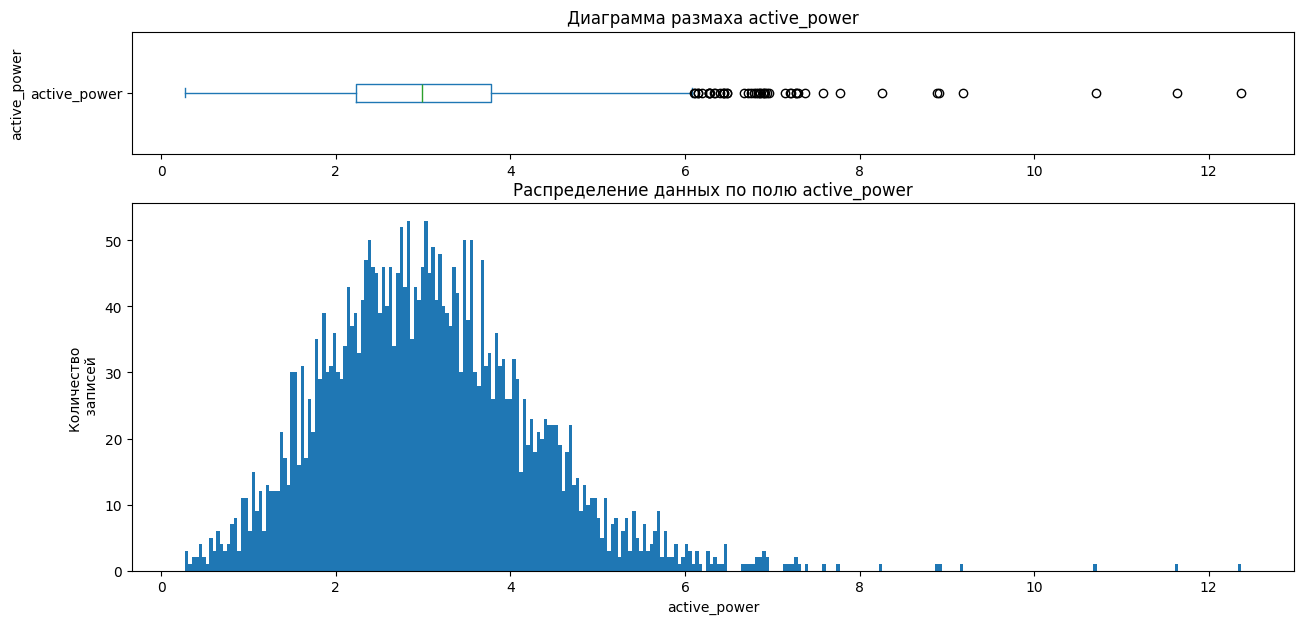

_____________________________________________________________________________________________________________________________
 
 Поле : reactive_power - reactive_power 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    3213.000000
mean        2.254693
std         0.894787
min         0.196228
25%         1.631855
50%         2.177210
75%         2.788381
max         8.949049
Name: reactive_power, dtype: float64


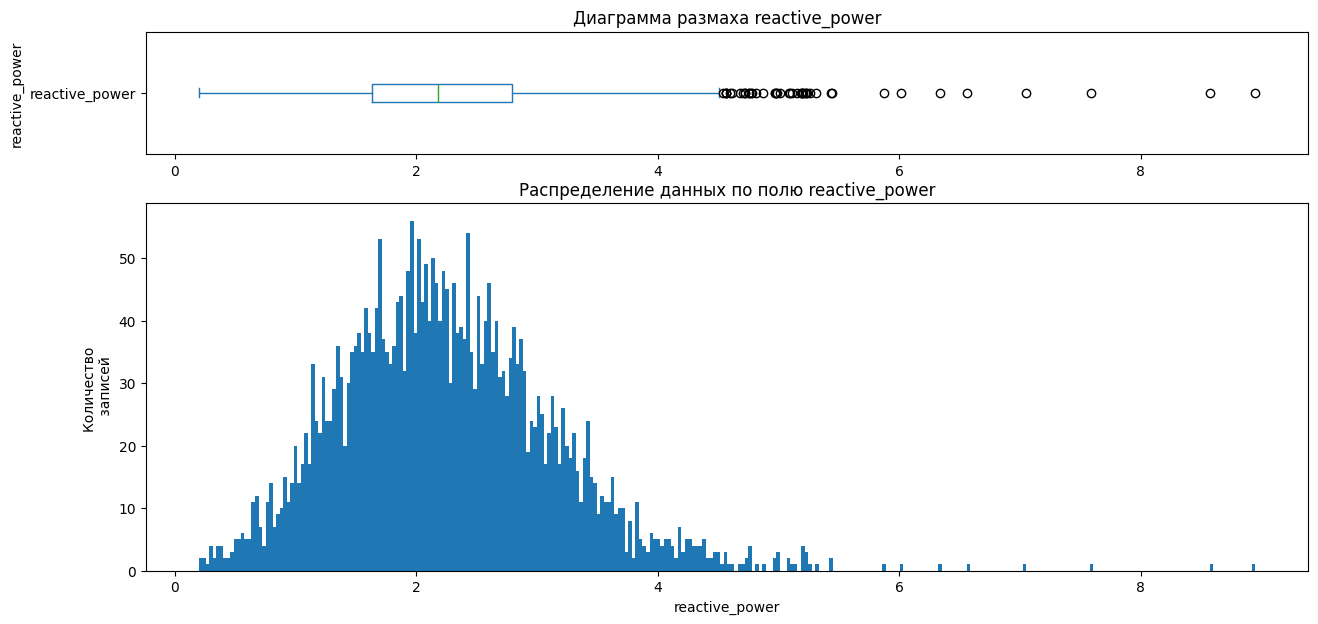

_____________________________________________________________________________________________________________________________
 
 Поле : heating_time - heating_time 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    3213.000000
mean      794.691566
std       332.439136
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: heating_time, dtype: float64


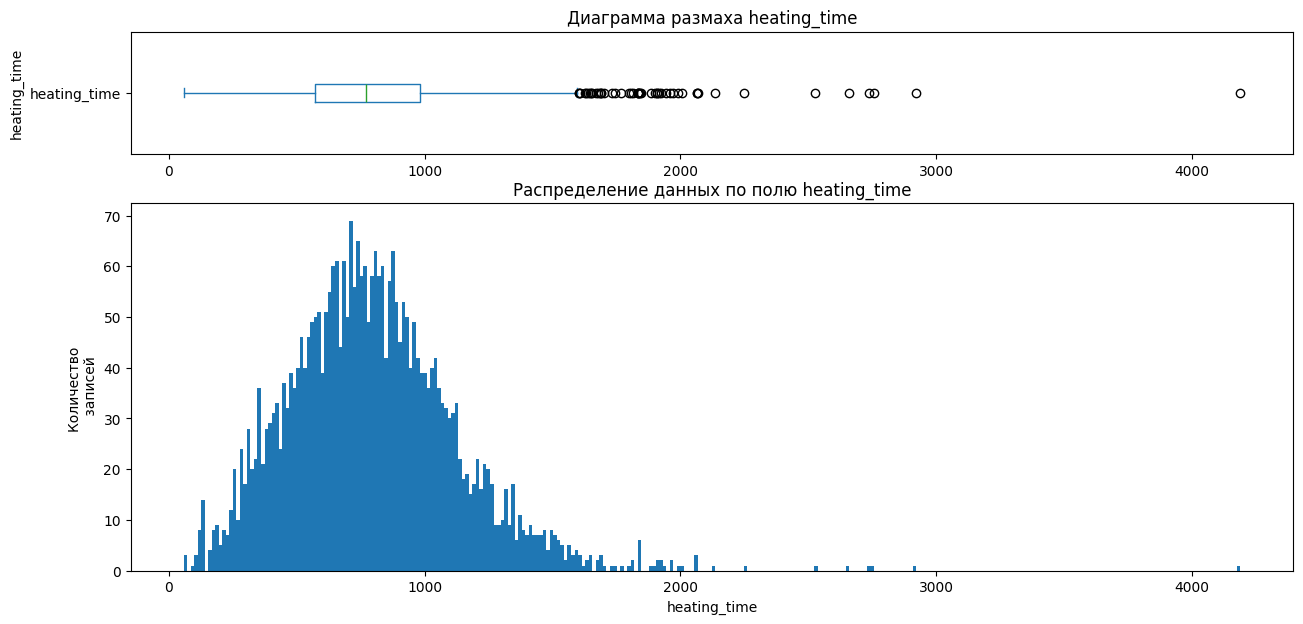

_____________________________________________________________________________________________________________________________
 
 Поле : power - power 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    3213.000000
mean        3.811201
std         1.502848
min         0.331897
25%         2.775577
50%         3.694535
75%         4.697427
max        15.288271
Name: power, dtype: float64


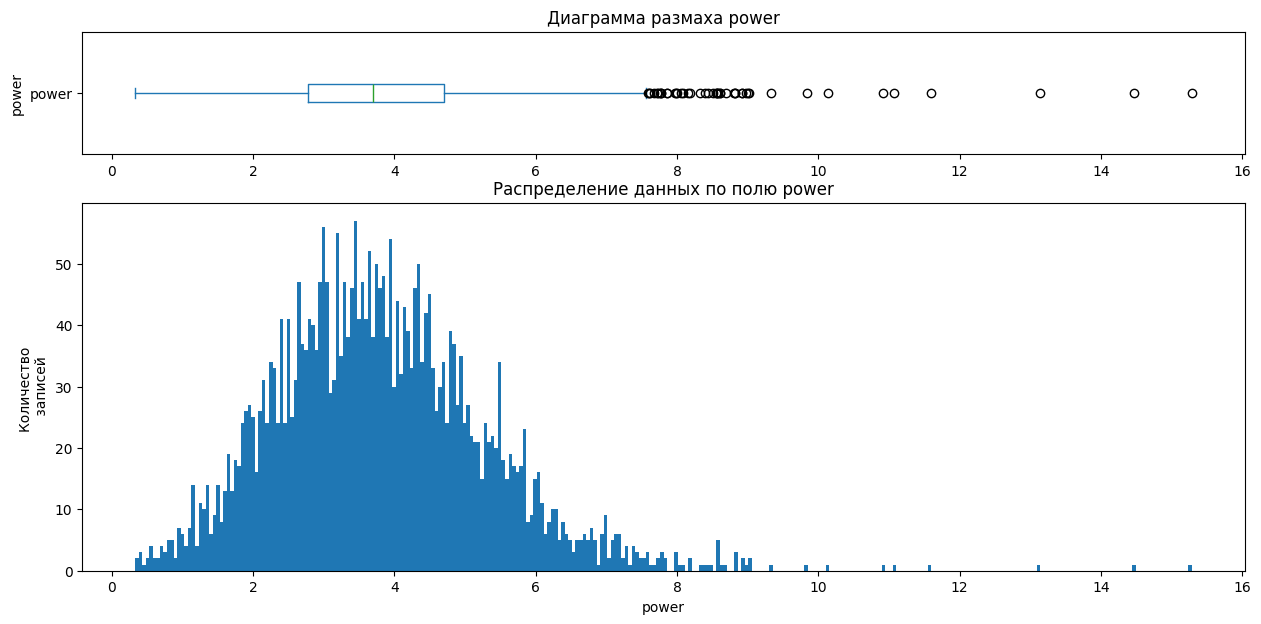

_____________________________________________________________________________________________________________________________
 
 Поле : energy - energy 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    3213.000000
mean      655.688884
std       308.950188
min        33.430208
25%       444.864502
50%       620.111140
75%       827.784614
max      4546.405812
Name: energy, dtype: float64


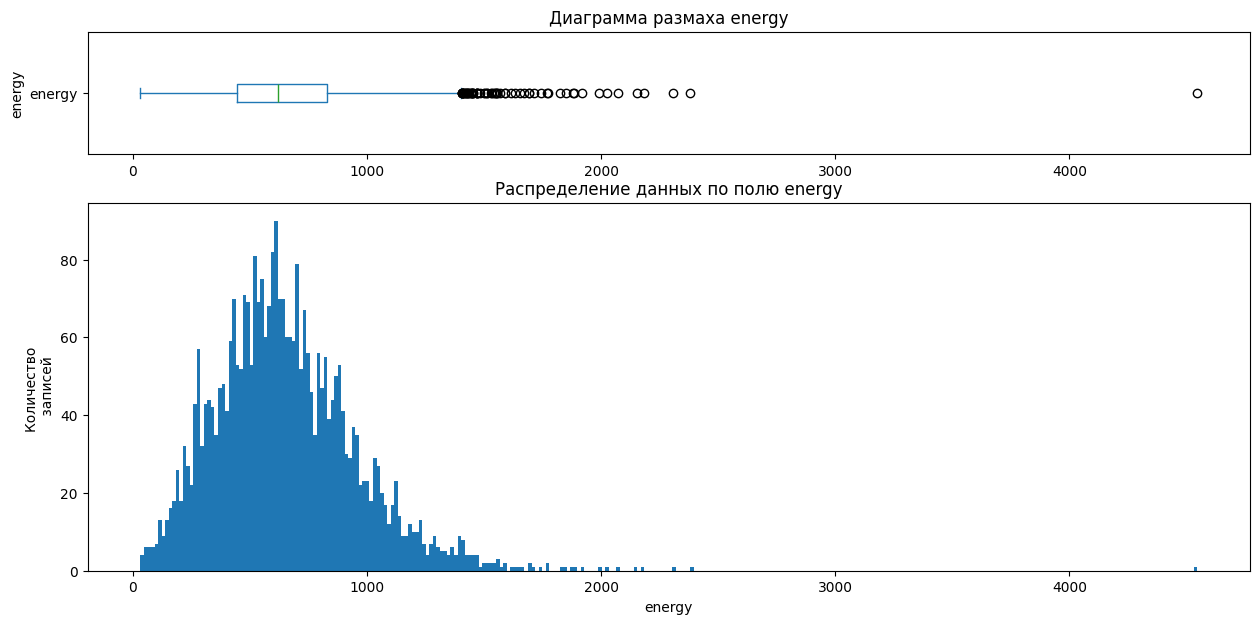

_____________________________________________________________________________________________________________________________
 
 Поле : heating_count - heating_count 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    3213.000000
mean        4.628696
std         1.608860
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: heating_count, dtype: float64


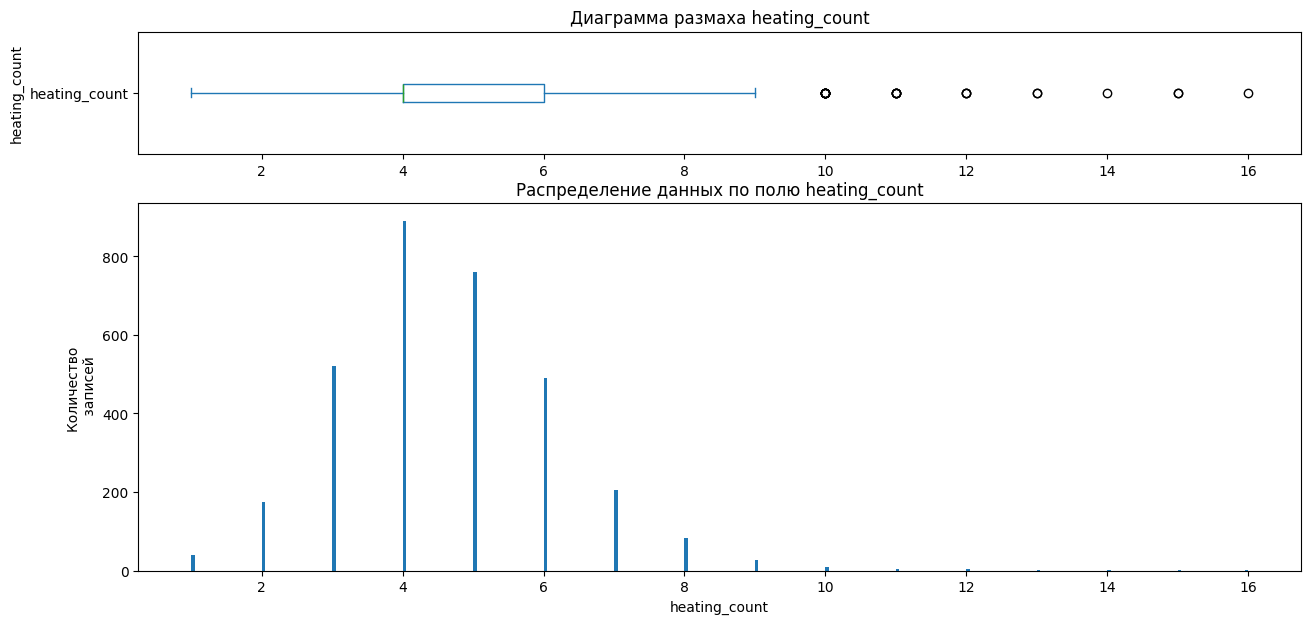

In [43]:
numeric_cols = arc_agg_df.select_dtypes(include = 'number').columns

for current_field in numeric_cols:
    # print(current_df[current_field].dtypes)
        
    box_plot_title = 'Диаграмма размаха ' + current_field
    hist_title = 'Распределение данных по полю ' + current_field

    column_analiser(
        arc_agg_df,
        current_field,
        x_label = current_field,
        y_label = 'Количество \n записей',
                
        box_plot_title = [box_plot_title],
        hist_title = [hist_title],
        print_unique = False,
        bins_= 300,
        figsize_ = (15, 7),
        height_ratios_ = [1, 3],
        hue_lst_ = [],
        kde_plot_log_flag_ = False,
        kde_plot_figsize_ = (15, 4),
        kde_plot_title = '',
        kde_plot_x_label = '',
        kde_plot_y_label = '')


### Удаление выбросов

<div class="well">
<font color='blue'><b>Комментарий ментора v2</b></font><br>
По  поводу аномалий сделал все верно. Аномалии во всем датасете не нужны

## **`Выводы`**

* `arc_agg_df` содержит информацию о `3129 наблюдениях`
* удалены записи, содержащие информацию о наблюдениях с аномальным значением `reactive_power < 0`
* Формирование признака `heating_time` - длительность нагрева (сек).
* Сформировавны признаки:
    * `power` - полная мощьность. Полная мощность рассчитывается как квадратный корень из суммы квадратов полной и реактивной мощностей. [Материалы по расчету полной мощности.](https://khomovelectro.ru/articles/aktivnaya-reaktivnaya-i-polnaya-kazhushchayasya-moshchnosti.html "Материалы по расчету полной мощности.")
    * `energy` - израсходованная электроэнергия [Материалы по расчету расхода электроэнергии.](https://om-ek.ru/index.php?route=octemplates/blog_article&oct_blog_article_id=154 "Материалы по расчету расхода электроэнергии.")
    * `heating_count` (количество нагревов для каждой партии)
* Сформирован датафрейм `arc_agg_df`, содержащий агрегированную по полю `key` информацию из `arc_agg_df`
* Удалена информация о наблюдении с температурой нагрева >= 4000

## **`temp_df`**

### Исключение записей с температурой < 1500

In [44]:
# Установка заказчика - значения температуры ниже 1500 градусов — аномальные
temp_df = temp_df.loc[temp_df['temperature'] >= 1500.0]

### Агрегация по key

In [45]:
# Формирование признаков
# measurement_count - количество измерений
# first_time_measurement - время первого измерения
# first_temperature - температура первого измерения
# last_time_measurement  - время последнего измерения
# last_temperature - температура последнего измерения

temp_agg_df = pd.DataFrame({
    'measurement_count' : temp_df.groupby('key')['temperature'].count(),
    'first_time_measurement' : temp_df.groupby('key')['measurement_time'].first().values,
    'first_temperature' : temp_df.groupby('key')['temperature'].first().values,
    'last_time_measurement' : temp_df.groupby('key')['measurement_time'].last().values,
    'last_temperature' : temp_df.groupby('key')['temperature'].last().values
})

### Удаление партий, в которых был только один замер

In [46]:
# При агрегировании наблюдений используйте только ключи,
# у которых как минимум два наблюдения: первый и последний замеры температуры.

temp_agg_df = temp_agg_df.loc[temp_agg_df['measurement_count'] > 1]

### Проверка на адекватность

In [47]:
print(blue_start, 'Количество записей, удовлетворяющих аномальному условию - first_time_measurement > last_time_measurement = ', color_end, len(temp_agg_df.query('first_time_measurement > last_time_measurement')))

 Количество записей, удовлетворяющих аномальному условию - first_time_measurement > last_time_measurement =   0


In [48]:
print(blue_start, 'Количество записей, удовлетворяющих аномальному условию - first_temperature > last_temperature = ', color_end, len(temp_agg_df.query('first_time_measurement > last_time_measurement')))

 Количество записей, удовлетворяющих аномальному условию - first_temperature > last_temperature =   0


### Характеристики агрегированного датасета temp_agg_df

### Визуализация характеристик полей temp_agg_df

## **`Выводы`**

* `temp_df` содержит информацию о `18092 наблюдениях`
* удалены записи, содержащие информацию о наблюдениях с аномальным значением `temperature >= 1500`
* Сформирован датафрейм `temp_agg_df`, содержащий агрегированную по полю `key` информацию из `temp_df`
* Удалена информация о наблюдении с температурой нагрева >= 4000
* Сформированы признаки:
    * `measurement_count` - количество наблюдений
    * `first_time_measurement` - время первого замера
    * `first_temperature` - температура при первом замере
    * `last_time_measurement` - время последнего замера
    * `last_temperature` - температура при последнем замере
* Удалена информация о наблюдениях с одним замером (проектное требование)

## **`bulk_df`**

### Формирование признака total_bulk_quant - сумма значений всех полей bulk по каждой записи

In [49]:
# Формирование свойства total_bulk_quant -  общее количество сыпучих материалов

bulk_field_lst = [
    'bulk_1',
    'bulk_2',
    'bulk_3',
    'bulk_4',
    'bulk_5',
    'bulk_6',
    'bulk_7',
    'bulk_8',
    'bulk_9',
    'bulk_10',
    'bulk_11',
    'bulk_12',
    'bulk_13',
    'bulk_14',
    'bulk_15']

bulk_df['total_bulk_quant'] = bulk_df[bulk_field_lst].sum(axis = 1)

### Формирование агрегированного bulk_df (bulk_agg_df)

In [50]:
bulk_agg_df = bulk_df.groupby('key').agg({
    'bulk_1' : 'sum',
    'bulk_2' : 'sum',
    'bulk_3' : 'sum',
    'bulk_4' : 'sum',
    'bulk_5' : 'sum',
    'bulk_6' : 'sum',
    'bulk_7' : 'sum',
    'bulk_8' : 'sum',
    'bulk_9' : 'sum',
    'bulk_10' : 'sum',
    'bulk_11' : 'sum',
    'bulk_12' : 'sum',
    'bulk_13' : 'sum',
    'bulk_14' : 'sum',
    'bulk_15' : 'sum',
    'total_bulk_quant' : 'sum'
})# .reset_index()

### Информация по агрегированному bulk_df (bulk_agg_df)

In [51]:
bulk_agg_df.name = 'bulk_agg_df'

duplicates_df,  bulk_agg_df__original_shape = df_inf(
    bulk_agg_df,
    head_row = 3,
    drop_duplicates_flag = False)

 ________________________________________________________________________________________ 
 Имя датафрейма: bulk_agg_df 
 ________________________________________________________________________________________ 

 bulk_agg_df (первые 3 строк) 


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,total_bulk_quant
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 3128 entries, 1 to 3241
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bulk_1            3128 non-null   float64
 1   bulk_2            3128 non-null   float64
 2   bulk_3            3128 non-null   float64
 3   bulk_4            3128 non-null   float64
 4   bulk_5            3128 non-null   float64
 5   bulk_6            3128 non-null   float64
 6   bulk_7            3128 non-null   float64
 7   bulk_8            3128 non-null   float64
 8   bulk_9            3128 non-null   float64
 9   bulk_10           3128 non-null   float64
 10  bulk_11           3128 non-null   float64
 11  bulk_12           3128 non-null   float64
 12  bulk_13           3128 non-null   float64
 13  bulk_14           3128 non-null   float64
 14  bulk_15           3128 non-null   float64
 15  total_bulk_quant  3128 non-null   float64
dtypes: float64(16)
memory usage: 41

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,total_bulk_quant
count,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000
mean,3.161445,1.779731,47.255435,33.841432,2.634591,21.855499,2.442455,0.015665,0.463555,4.686061,4.346867,204.013427,1.042199,152.692136,115.356138,595.586637
std,11.870928,21.221246,74.247016,56.040198,20.921430,55.463257,31.949140,0.876118,6.155377,20.160372,22.703077,151.399912,14.116497,81.100341,84.477031,276.562767
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,429.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000,591.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000,772.250000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


bulk_1              0
bulk_2              0
bulk_3              0
bulk_4              0
bulk_5              0
bulk_6              0
bulk_7              0
bulk_8              0
bulk_9              0
bulk_10             0
bulk_11             0
bulk_12             0
bulk_13             0
bulk_14             0
bulk_15             0
total_bulk_quant    0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 
 Количество дубликатов: 80 
 Дубликаты (первые 3 строк) 


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,total_bulk_quant
key,,,,,,,,,,,,,,,,
323,0.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0
618,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
765,0.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0


bulk_agg_df.query('total_bulk_quant == 19.0')

### Использование различных сыпучих материалов

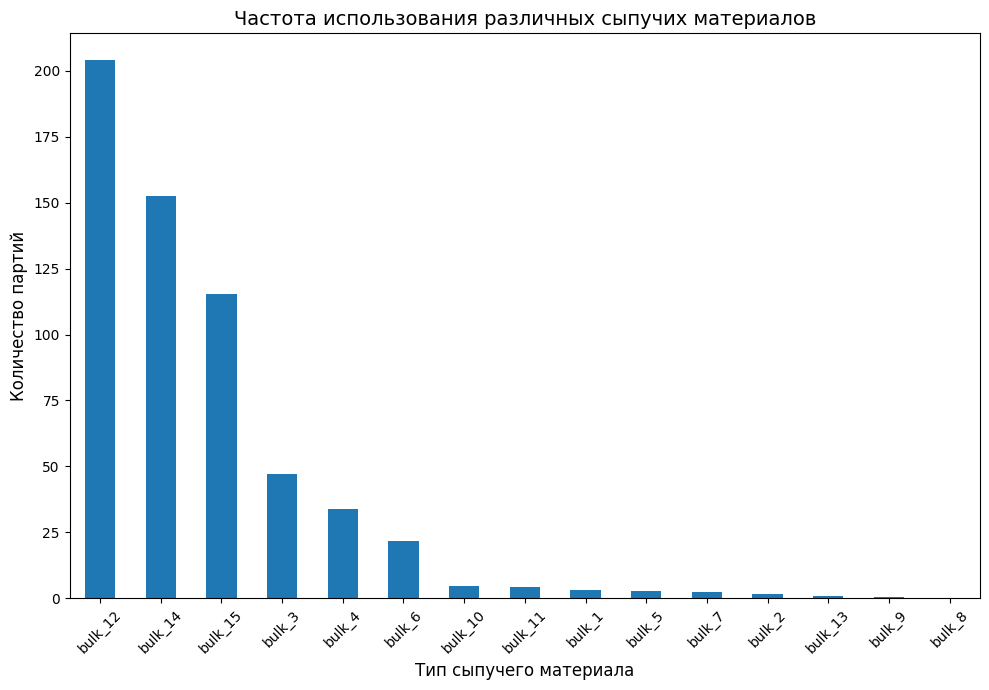

In [52]:
multiple_column_analiser(
    data = bulk_agg_df[[
    'bulk_1',
    'bulk_2',
    'bulk_3',
    'bulk_4',
    'bulk_5',
    'bulk_6',
    'bulk_7',
    'bulk_8',
    'bulk_9',
    'bulk_10',
    'bulk_11',
    'bulk_12',
    'bulk_13',
    'bulk_14',
    'bulk_15']].mean().sort_values(ascending=False),
    plot='p',
    title='Частота использования различных сыпучих материалов',
    xlabel='Тип сыпучего материала',
    ylabel='Количество партий')

## **`Выводы`**

* `bulk_df` содержит информацию о `3128 наблюдениях`
* Сформирован признак `total_bulk_quant` - сумма значений `bulk_1` ... `bulk_15`
* Сформирован датафрейм `bulk_agg_df`, содержащий агрегированную по полю `key` информацию из `bulk_df`
* Часто используемые материалы - `bulk_12, bulk_14, bulk_15, bulk_13, bulk_4, bulk_6`. Остальные сыпучие материалы используются значительно реже.

## **`wire_df`**

### Формирование признака total_wire_quant - сумма значений всех полей wire по каждой записи

In [53]:
# Формирование свойства total_wire_quant -  общее количество проволочных материалов
# Определиться с алгоритмом

wire_df['total_wire_quant'] = wire_df[[
    'wire_1',
    'wire_2',
    'wire_3',
    'wire_4',
    'wire_5',
    'wire_6',
    'wire_7',
    'wire_8',
    'wire_9'
                                ]].sum(axis = 1)

### Формирование агрегированного wire_df (wire_agg_df)

In [54]:
wire_agg_df = wire_df.groupby('key').agg({
    'wire_1' : 'sum',
    'wire_2' : 'sum',
    'wire_3' : 'sum',
    'wire_4' : 'sum',
    'wire_5' : 'sum',
    'wire_6' : 'sum',
    'wire_7' : 'sum',
    'wire_8' : 'sum',
    'wire_9' : 'sum',
    'total_wire_quant' : 'sum'
})# .reset_index()

### Информация по агрегированному wire_df (wire_agg_df)

In [55]:
wire_agg_df.name = 'wire_agg_df'

duplicates_df,  wire_agg_df__original_shape = df_inf(
    wire_agg_df,
    head_row = 3,
    drop_duplicates_flag = False)

 ________________________________________________________________________________________ 
 Имя датафрейма: wire_agg_df 
 ________________________________________________________________________________________ 

 wire_agg_df (первые 3 строк) 


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_wire_quant
key,,,,,,,,,,
1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 3080 entries, 1 to 3241
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   wire_1            3080 non-null   float64
 1   wire_2            3080 non-null   float64
 2   wire_3            3080 non-null   float64
 3   wire_4            3080 non-null   float64
 4   wire_5            3080 non-null   float64
 5   wire_6            3080 non-null   float64
 6   wire_7            3080 non-null   float64
 7   wire_8            3080 non-null   float64
 8   wire_9            3080 non-null   float64
 9   total_wire_quant  3080 non-null   float64
dtypes: float64(10)
memory usage: 264.7 KB

 Описание числовых полей:  


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_wire_quant
count,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000
mean,100.052472,17.718484,3.875782,0.261104,0.004913,1.138065,0.035854,0.330805,0.321596,123.739075
std,42.845739,33.521656,30.315258,4.294559,0.272660,8.959543,0.774316,4.393387,3.807517,66.087914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.918800
25%,70.260839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.147092
50%,100.133278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,114.179525
75%,125.820243,23.170420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.184578
max,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604,663.851766



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


wire_1              0
wire_2              0
wire_3              0
wire_4              0
wire_5              0
wire_6              0
wire_7              0
wire_8              0
wire_9              0
total_wire_quant    0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 
 Количество дубликатов: 402 
 Дубликаты (первые 3 строк) 


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_wire_quant
key,,,,,,,,,,
152,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
182,37.084320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.084320
259,55.080479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.080479


### Использование различных проволочных материалов

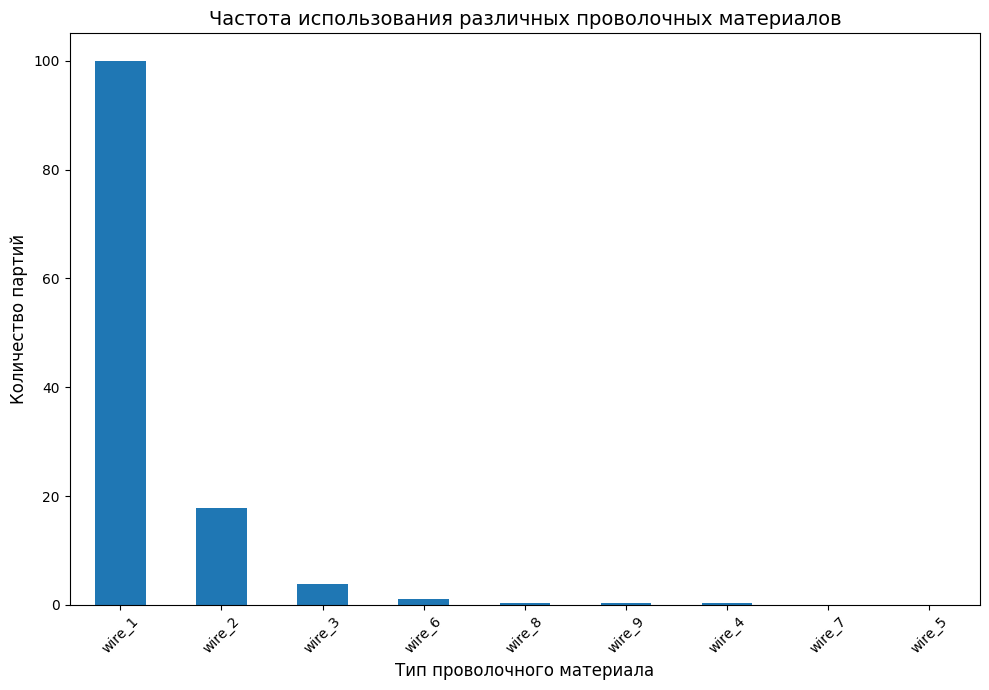

In [56]:
multiple_column_analiser(
    data = wire_agg_df[[
    'wire_1',
    'wire_2',
    'wire_3',
    'wire_4',
    'wire_5',
    'wire_6',
    'wire_7',
    'wire_8',
    'wire_9']].mean().sort_values(ascending=False),
    plot='p',
    title='Частота использования различных проволочных материалов',
    xlabel='Тип проволочного материала',
    ylabel='Количество партий')

## **`Выводы`**

* `wire_df` содержит информацию о `3080 наблюдениях`
* Сформирован признак `total_wire_quant` - сумма значений `wire_1` ... `wire_9`
* Сформирован датафрейм `bulk_agg_df`, содержащий агрегированную по полю `key` информацию из `bulk_df`
* Часто используемые материалы - `wire_1 и wire_2`. Остальные проволочные материалы используются значительно реже.

## **`gas_df`**

In [57]:
gas_df.name = 'gas_df'
duplicates_df, gas_df__original_shape = df_inf(gas_df, head_row = 3, drop_duplicates_flag = False)

 ________________________________________________________________________________________ 
 Имя датафрейма: gas_df 
 ________________________________________________________________________________________ 

 gas_df (первые 3 строк) 


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 3238 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3238 non-null   int64  
 1   gas     3238 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.9 KB

 Описание числовых полей:  


,key,gas
count,3238.000000,3238.000000
mean,1621.708771,11.001883
std,935.490478,6.221280
min,1.000000,0.008399
25%,812.250000,7.042678
50%,1621.500000,9.832531
75%,2431.750000,13.770937
max,3241.000000,77.995040



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


key    0
gas    0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 


_____________________________________________________________________________________________________________________________
 
 Поле : gas - gas 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    3238.000000
mean       11.001883
std         6.221280
min         0.008399
25%         7.042678
50%         9.832531
75%        13.770937
max        77.995040
Name: gas, dtype: float64


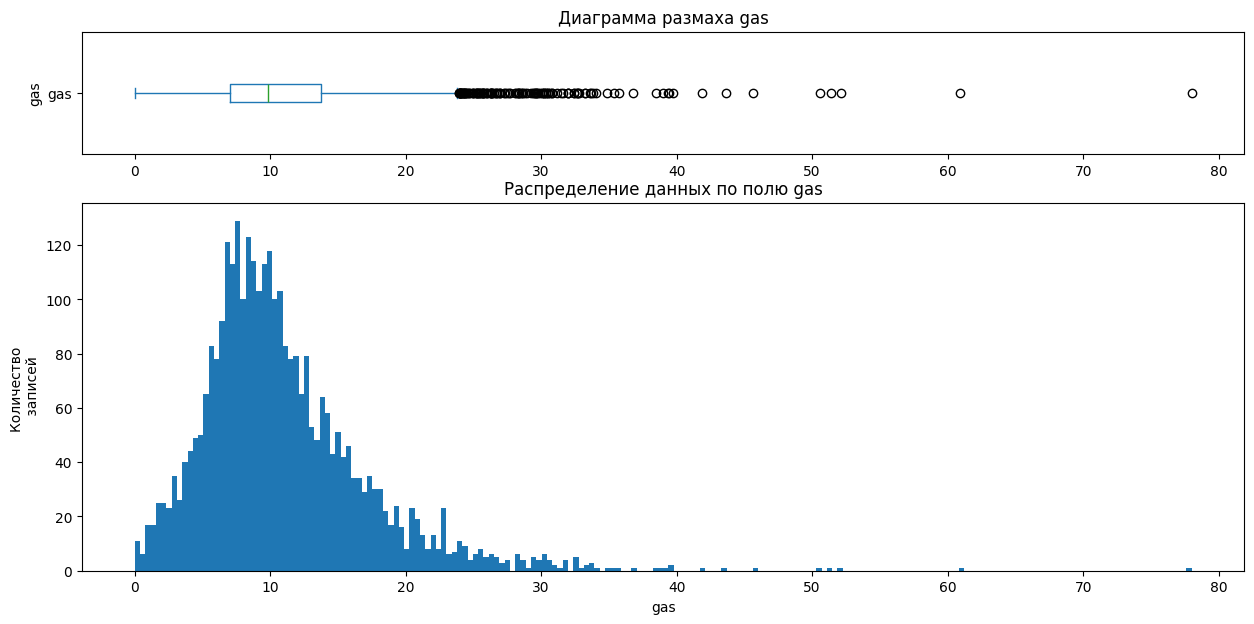

In [58]:
numeric_cols = [
    'gas'
               ]

for current_field in numeric_cols:
    # print(current_df[current_field].dtypes)
        
    box_plot_title = 'Диаграмма размаха ' + current_field
    hist_title = 'Распределение данных по полю ' + current_field

    column_analiser(
        gas_df,
        current_field,
        x_label = current_field,
        y_label = 'Количество \n записей',
                
        box_plot_title = [box_plot_title],
        hist_title = [hist_title],
        print_unique = False,
        bins_= 200,
        figsize_ = (15, 7),
        height_ratios_ = [1, 3],
        hue_lst_ = [],
        kde_plot_log_flag_ = False,
        kde_plot_figsize_ = (15, 4),
        kde_plot_title = '',
        kde_plot_x_label = '',
        kde_plot_y_label = '')

## **`Выводы`**

* `gas_df` содержит информацию о `3238 наблюдениях`

## **`wire_time_dh`** и **`bulk_time_dh`**

## **`Выводы`**

* Датасеты **`wire_time_dh`** и **`bulk_time_dh`** содеожат информацию овремени подачи сыпучих и проволочных материалов.
* Для расчета признаков, необходимо для прогноза финальной температуры достаточно данных о количестве добавок, нагревах и измерении температур.
* Если данных для успешного формирования прогнозной модели, утсановленного в проекте качества, будет не достаточно, данные из **`wire_time_dh`** и **`bulk_time_dh`** будут использованы для формирования дополнительных признаков.

# Трансформация поля key в индекс по всем исходным таблицам

In [59]:
# трансформация поля key в индекс по всем таблицам
for key, value in table_lst.items():
#    print(key, value)
    data_frame_dv = key
    vars()[data_frame_dv].set_index('key', inplace = True)

# Подготовка данных для обучения

## Формирование объединенного датафрейма - main_df

In [60]:
# Объединение агрегированных датасетов

print(len(temp_agg_df))
main_df = temp_agg_df.join([arc_agg_df, bulk_agg_df, wire_agg_df, gas_df], how = 'inner')
print(len(main_df))

2474
2328


### Характеристики датасета объединенных агрегированных данных

In [61]:
main_df.name = 'main_df'
duplicates_df, main_df__original_shape = df_inf(main_df, head_row = 3, drop_duplicates_flag = False)

 ________________________________________________________________________________________ 
 Имя датафрейма: main_df 
 ________________________________________________________________________________________ 

 main_df (первые 3 строк) 


,measurement_count,first_time_measurement,first_temperature,last_time_measurement,last_temperature,start_heating,stop_heating,active_power,reactive_power,heating_time,power,energy,heating_count,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,total_bulk_quant,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_wire_quant,gas
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,6,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,3.036730,2.142821,1098.0,3.718736,770.282114,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
2,5,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,2.139408,1.453357,811.0,2.588349,481.760005,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
3,6,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,4.063641,2.937457,655.0,5.019223,722.837668,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 2328 entries, 1 to 2499
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   measurement_count       2328 non-null   int64         
 1   first_time_measurement  2328 non-null   datetime64[ns]
 2   first_temperature       2328 non-null   float64       
 3   last_time_measurement   2328 non-null   datetime64[ns]
 4   last_temperature        2328 non-null   float64       
 5   start_heating           2328 non-null   datetime64[ns]
 6   stop_heating            2328 non-null   datetime64[ns]
 7   active_power            2328 non-null   float64       
 8   reactive_power          2328 non-null   float64       
 9   heating_time            2328 non-null   float64       
 10  power                   2328 non-null   float64       
 11  energy                  2328 non-null   float64       
 12  heating_count           2328 non-null

,measurement_count,first_time_measurement,first_temperature,last_time_measurement,last_temperature,start_heating,stop_heating,active_power,reactive_power,heating_time,power,energy,heating_count,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,total_bulk_quant,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_wire_quant,gas
count,2328.000000,2328,2328.000000,2328,2328.000000,2328,2328,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.0,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000
mean,5.694158,2019-06-21 00:22:25.462628864,1587.389605,2019-06-21 01:01:07.533934592,1593.371993,2019-06-21 00:22:34.372422656,2019-06-21 00:55:46.937714688,3.125546,2.300860,807.808419,3.885267,669.912912,4.695876,3.429124,1.423110,47.368557,37.319588,2.641323,22.381014,2.005584,0.021048,0.445017,5.054983,4.246993,208.505155,1.067869,153.834622,120.004296,609.748282,102.455296,17.617423,3.236305,0.306682,0.0,0.979240,0.006363,0.311445,0.317249,125.230004,11.375511
min,2.000000,2019-05-03 11:02:04,1519.000000,2019-05-03 11:30:38,1541.000000,2019-05-03 11:02:14,2019-05-03 11:28:37,0.267676,0.196228,57.000000,0.331897,33.430208,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.918800,0.008399
25%,5.000000,2019-05-27 11:37:49.249999872,1571.000000,2019-05-27 12:26:02,1587.000000,2019-05-27 11:37:59.249999872,2019-05-27 12:18:08.750000128,2.295340,1.670282,581.000000,2.843909,457.870652,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,440.000000,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,89.048700,7.282534
50%,6.000000,2019-06-19 21:16:02.500000,1587.000000,2019-06-19 21:46:40.500000,1593.000000,2019-06-19 21:16:12.500000,2019-06-19 21:42:46.500000,3.035834,2.225900,778.000000,3.768661,630.813815,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,609.000000,101.119202,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,116.106121,10.100687
75%,7.000000,2019-07-11 17:28:51.500000,1603.000000,2019-07-11 17:55:25.750000128,1598.000000,2019-07-11 17:29:01.500000,2019-07-11 17:51:52.750000128,3.834302,2.829179,993.000000,4.769753,841.459596,6.000000,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.250000,0.000000,204.000000,204.000000,795.250000,128.097058,23.110100,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,151.582857,14.216939
max,17.000000,2019-08-10 13:33:21,1660.000000,2019-08-10 13:58:58,1653.000000,2019-08-10 13:33:31,2019-08-10 13:56:17,12.375636,8.949049,4189.000000,15.288271,4546.405812,16.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,568.777664,77.995040
std,1.607920,NaN,23.624276,NaN,11.198791,NaN,NaN,1.221019,0.904016,340.823100,1.518195,319.493496,1.606909,12.414595,19.086196,75.320213,58.650737,22.407040,55.752272,30.682797,1.015558,6.221971,20.922031,22.520153,157.036569,14.238096,81.416698,84.622085,287.605102,43.545688,33.630013,27.948793,4.758764,0.0,8.695143,0.205749,4.403648,3.457298,63.688634,6.393413



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


measurement_count         0
first_time_measurement    0
first_temperature         0
last_time_measurement     0
last_temperature          0
start_heating             0
stop_heating              0
active_power              0
reactive_power            0
heating_time              0
power                     0
energy                    0
heating_count             0
bulk_1                    0
bulk_2                    0
bulk_3                    0
bulk_4                    0
bulk_5                    0
bulk_6                    0
bulk_7                    0
bulk_8                    0
bulk_9                    0
bulk_10                   0
bulk_11                   0
bulk_12                   0
bulk_13                   0
bulk_14                   0
bulk_15                   0
total_bulk_quant          0
wire_1                    0
wire_2                    0
wire_3                    0
wire_4                    0
wire_5                    0
wire_6                    0
wire_7              


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 


### Удаление записей не соответствующих условию проекта

In [62]:
main_df = main_df.fillna(0)

In [63]:
print(blue_start, 'Значения поля key - уникальны', color_end, main_df.reset_index()['key'].is_unique)
print(
    blue_start,
    'Количество наблюдений, в которых не добавляли bulk или wire - ',
    color_end,
    len(main_df.query('total_wire_quant == 0 & total_bulk_quant == 0'))
     )
print(
    blue_start,
    'Количество наблюдений, в которых не осуществлялась продувка газом - ',
    color_end,
    len(main_df.query('gas == 0'))
     )
print(
    blue_start,
    'Количество наблюдений, в которых сплав не нагревался - ',
    color_end,
    len(main_df.query('first_temperature == last_temperature'))
     )

# Удаление наблюдений, в которых температура не менялась, т.е. смесь не нагревалась 
main_df.query('first_temperature == last_temperature')
main_df = main_df.loc[~(main_df['first_temperature'] == main_df['last_temperature'])]


#arc_df = arc_df.reset_index()
#display(arc_df.loc[arc_df['key'] == 262])

#temp_df = temp_df.reset_index()
#display(temp_df.loc[temp_df['key'] == 262])

 Значения поля key - уникальны  True
 Количество наблюдений, в которых не добавляли bulk или wire -   0
 Количество наблюдений, в которых не осуществлялась продувка газом -   0
 Количество наблюдений, в которых сплав не нагревался -   37


### Удаление неинформативных полей

In [64]:
fields_to_delite = [
    'first_time_measurement',
    'last_time_measurement',
    'start_heating',
    'stop_heating']

main_df = main_df.drop(fields_to_delite, axis = 1)

### Проверка на адекватность объединенного датасета

In [65]:
print(
        blue_start,
        'Количество наблюдений без добавления сыпучих и проволочных материалов - ',
        color_end,
        len(main_df.query('total_wire_quant == 0 & total_bulk_quant == 0'))
     )
print(
        blue_start,
        'Количество наблюдений где суммарная энергия = 0 -  ',
        color_end, 
        len(main_df.query('power == 0'))
     )
print(
        blue_start,
        'Количество наблюдений где температура меньше 1500 -  ',
        color_end, 
        len(main_df.query('last_temperature < 1500 or first_temperature < 1500'))
)


 Количество наблюдений без добавления сыпучих и проволочных материалов -   0
 Количество наблюдений где суммарная энергия = 0 -    0
 Количество наблюдений где температура меньше 1500 -    0


### Изменение типов данных

In [66]:
field_lst = [
    'measurement_count',
    'first_temperature',
    'last_temperature',
    'heating_time',
    'heating_count',
    'total_bulk_quant',
    'total_wire_quant']

main_df = set_date_type(main_df, field_lst_ = field_lst, new_date_type = 'int')

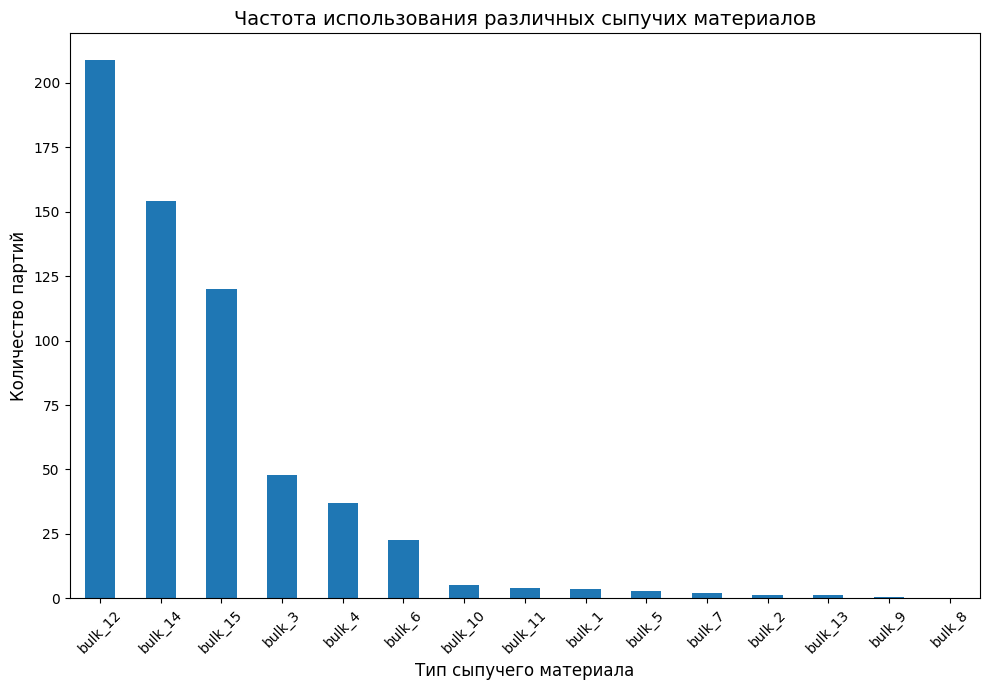

In [67]:
multiple_column_analiser(
    data = main_df[[
    'bulk_1',
    'bulk_2',
    'bulk_3',
    'bulk_4',
    'bulk_5',
    'bulk_6',
    'bulk_7',
    'bulk_8',
    'bulk_9',
    'bulk_10',
    'bulk_11',
    'bulk_12',
    'bulk_13',
    'bulk_14',
    'bulk_15']].mean().sort_values(ascending=False),
    plot='p',
    title='Частота использования различных сыпучих материалов',
    xlabel='Тип сыпучего материала',
    ylabel='Количество партий')

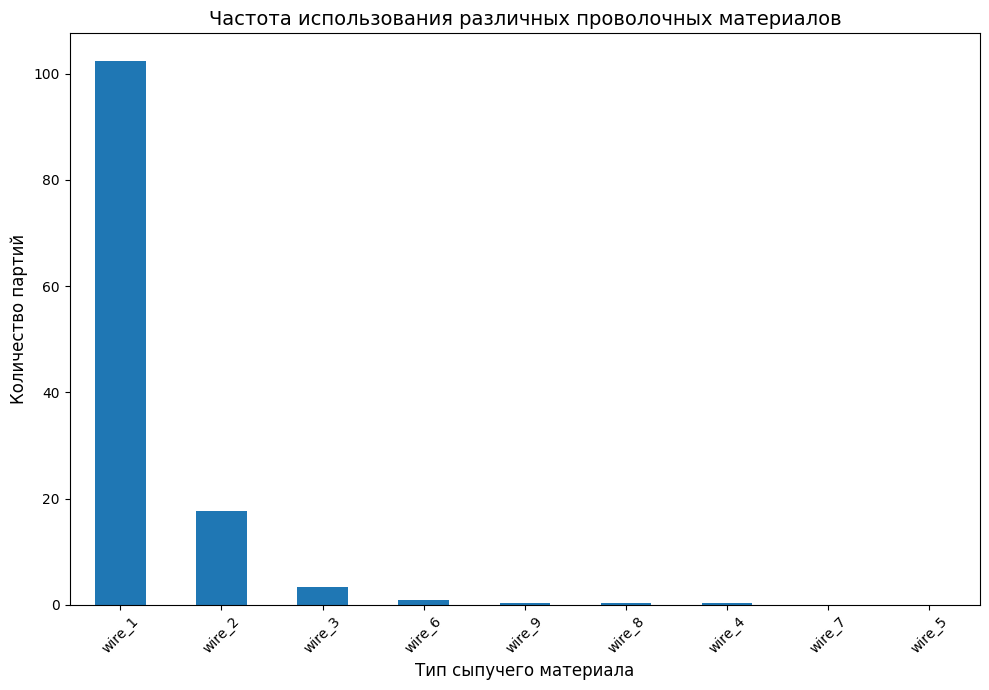

In [68]:
multiple_column_analiser(
    data = main_df[[
    'wire_1',
    'wire_2',
    'wire_3',
    'wire_4',
    'wire_5',
    'wire_6',
    'wire_7',
    'wire_8',
    'wire_9']].mean().sort_values(ascending=False),
    plot='p',
    title='Частота использования различных проволочных материалов',
    xlabel='Тип сыпучего материала',
    ylabel='Количество партий')

In [69]:
## **`wire_time_df`** и **`bulk_time_df`**

## Корреляционный анализ

In [70]:
train_test_df = main_df[[
'first_temperature',
'last_temperature',
'active_power',
'reactive_power',
'power',
'heating_time',
'heating_count',
'energy',
'total_bulk_quant',
'total_wire_quant',
'gas',
'bulk_1',
'bulk_2',
'bulk_3',
'bulk_4',
'bulk_5',
'bulk_6',
'bulk_7',
#'bulk_8',
#'bulk_9',
'bulk_10',
'bulk_11',
'bulk_12',
#'bulk_13',
'bulk_14',
'bulk_15',
'wire_1',
'wire_2',
'wire_3',
#'wire_4',
#'wire_5',
'wire_6',
#'wire_7',
#'wire_8',
#'wire_9'
]]

### По всем признакам train_test_df

interval columns not set, guessing: ['first_temperature', 'last_temperature', 'active_power', 'reactive_power', 'power', 'heating_time', 'heating_count', 'energy', 'total_bulk_quant', 'total_wire_quant', 'gas', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_6']


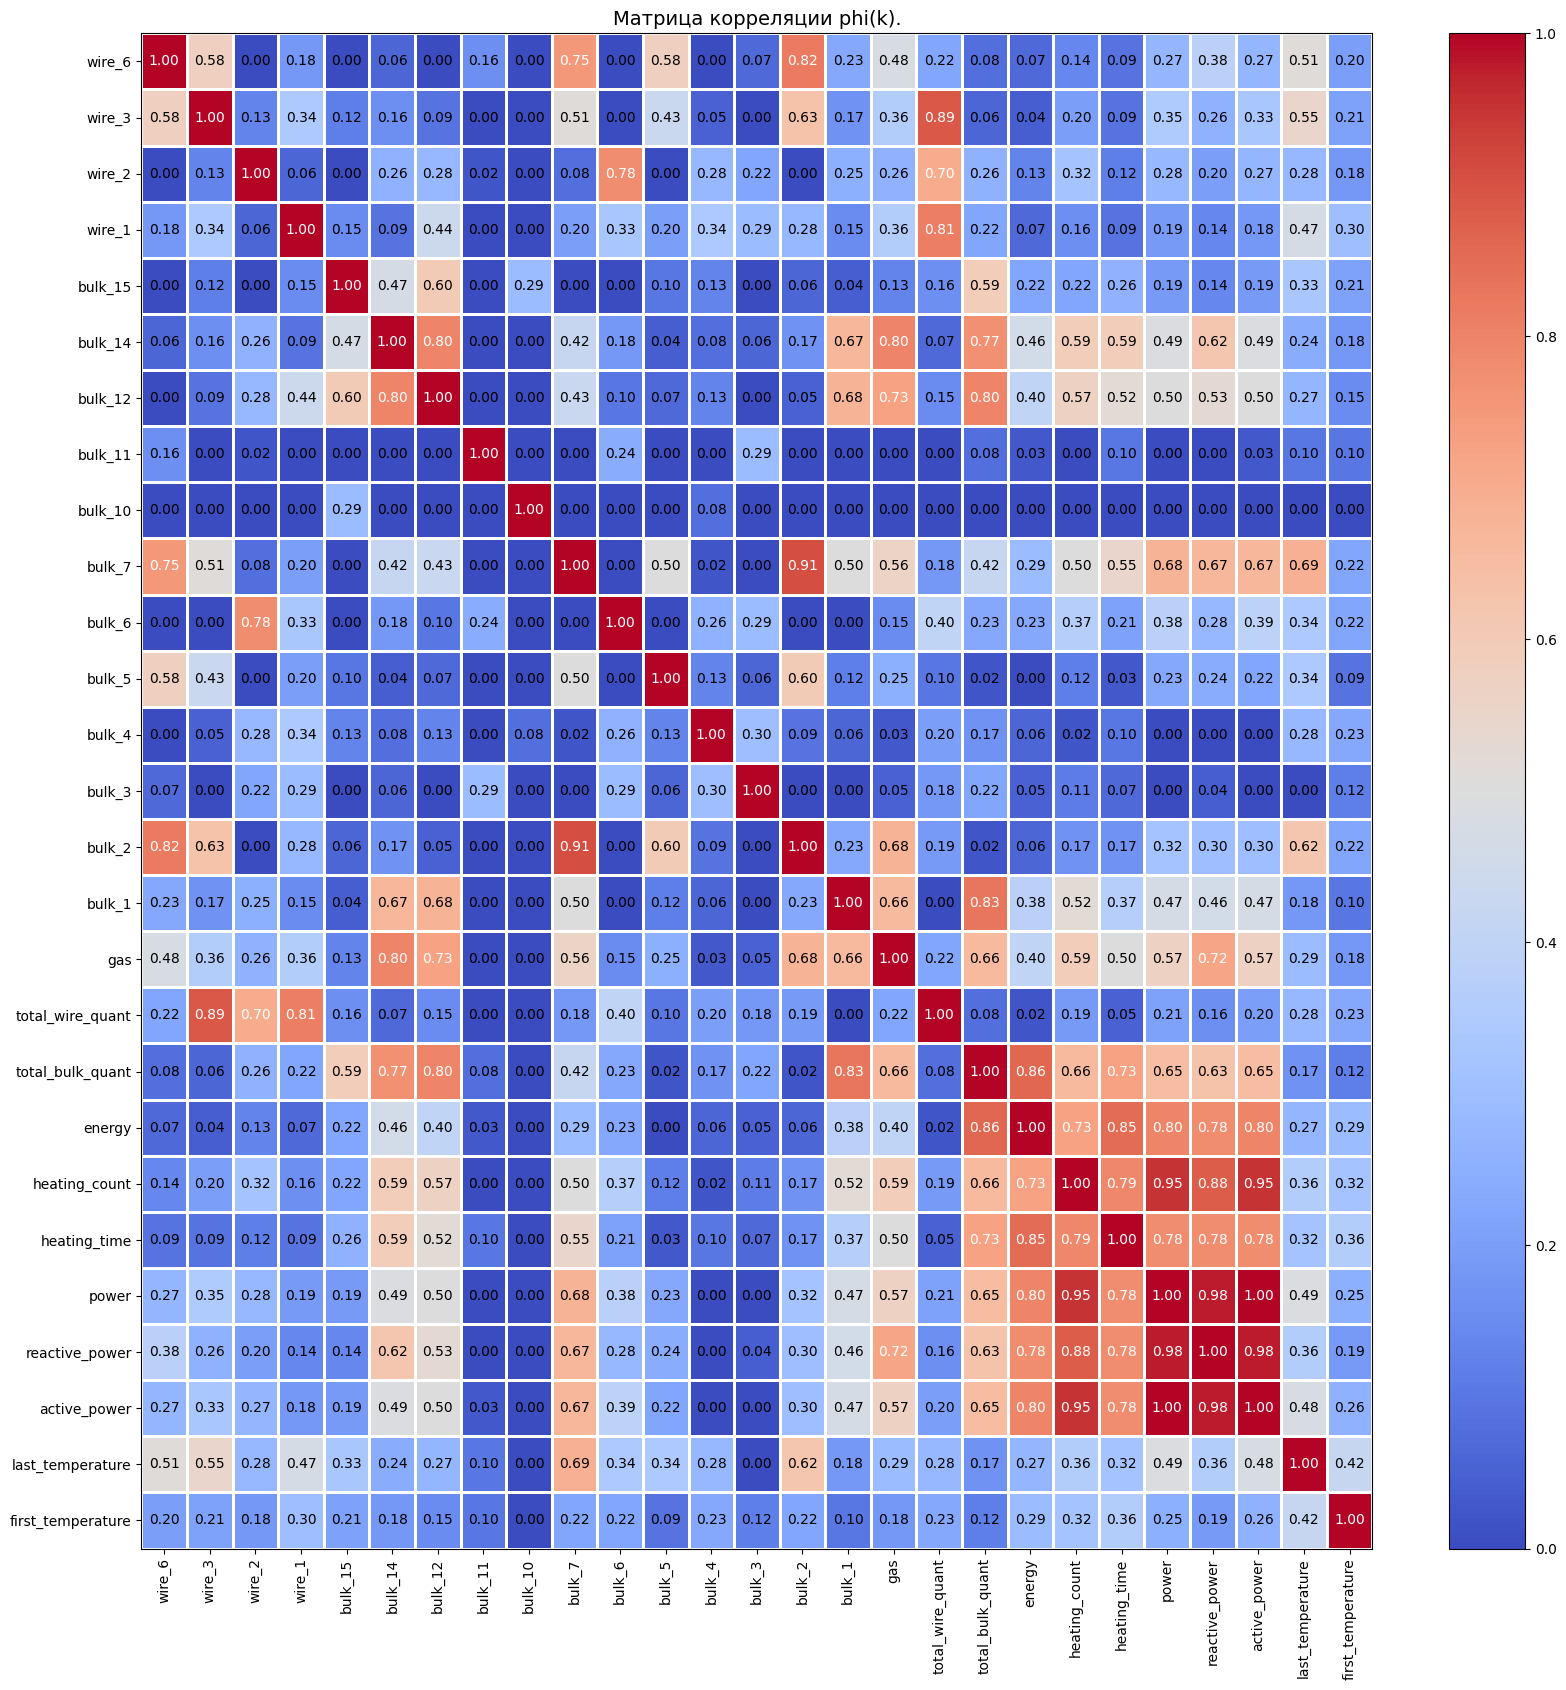

In [71]:
phik_date = train_test_df.phik_matrix().round(2)

plot_correlation_matrix(phik_date.values, 
                        x_labels = phik_date.columns, 
                        y_labels = phik_date.index, 
                        vmin = 0, vmax = 1, color_map = "coolwarm", 
                        title = 'Матрица корреляции phi(k).', 
                        fontsize_factor = 1, 
                        figsize = (17, 17));
plt.tight_layout()
plt.show()

### После исключения зависимостей > 0.95

In [72]:
train_test_df = train_test_df.drop(['active_power', 'reactive_power'], axis = 1)

interval columns not set, guessing: ['first_temperature', 'last_temperature', 'power', 'heating_time', 'heating_count', 'energy', 'total_bulk_quant', 'total_wire_quant', 'gas', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_6']


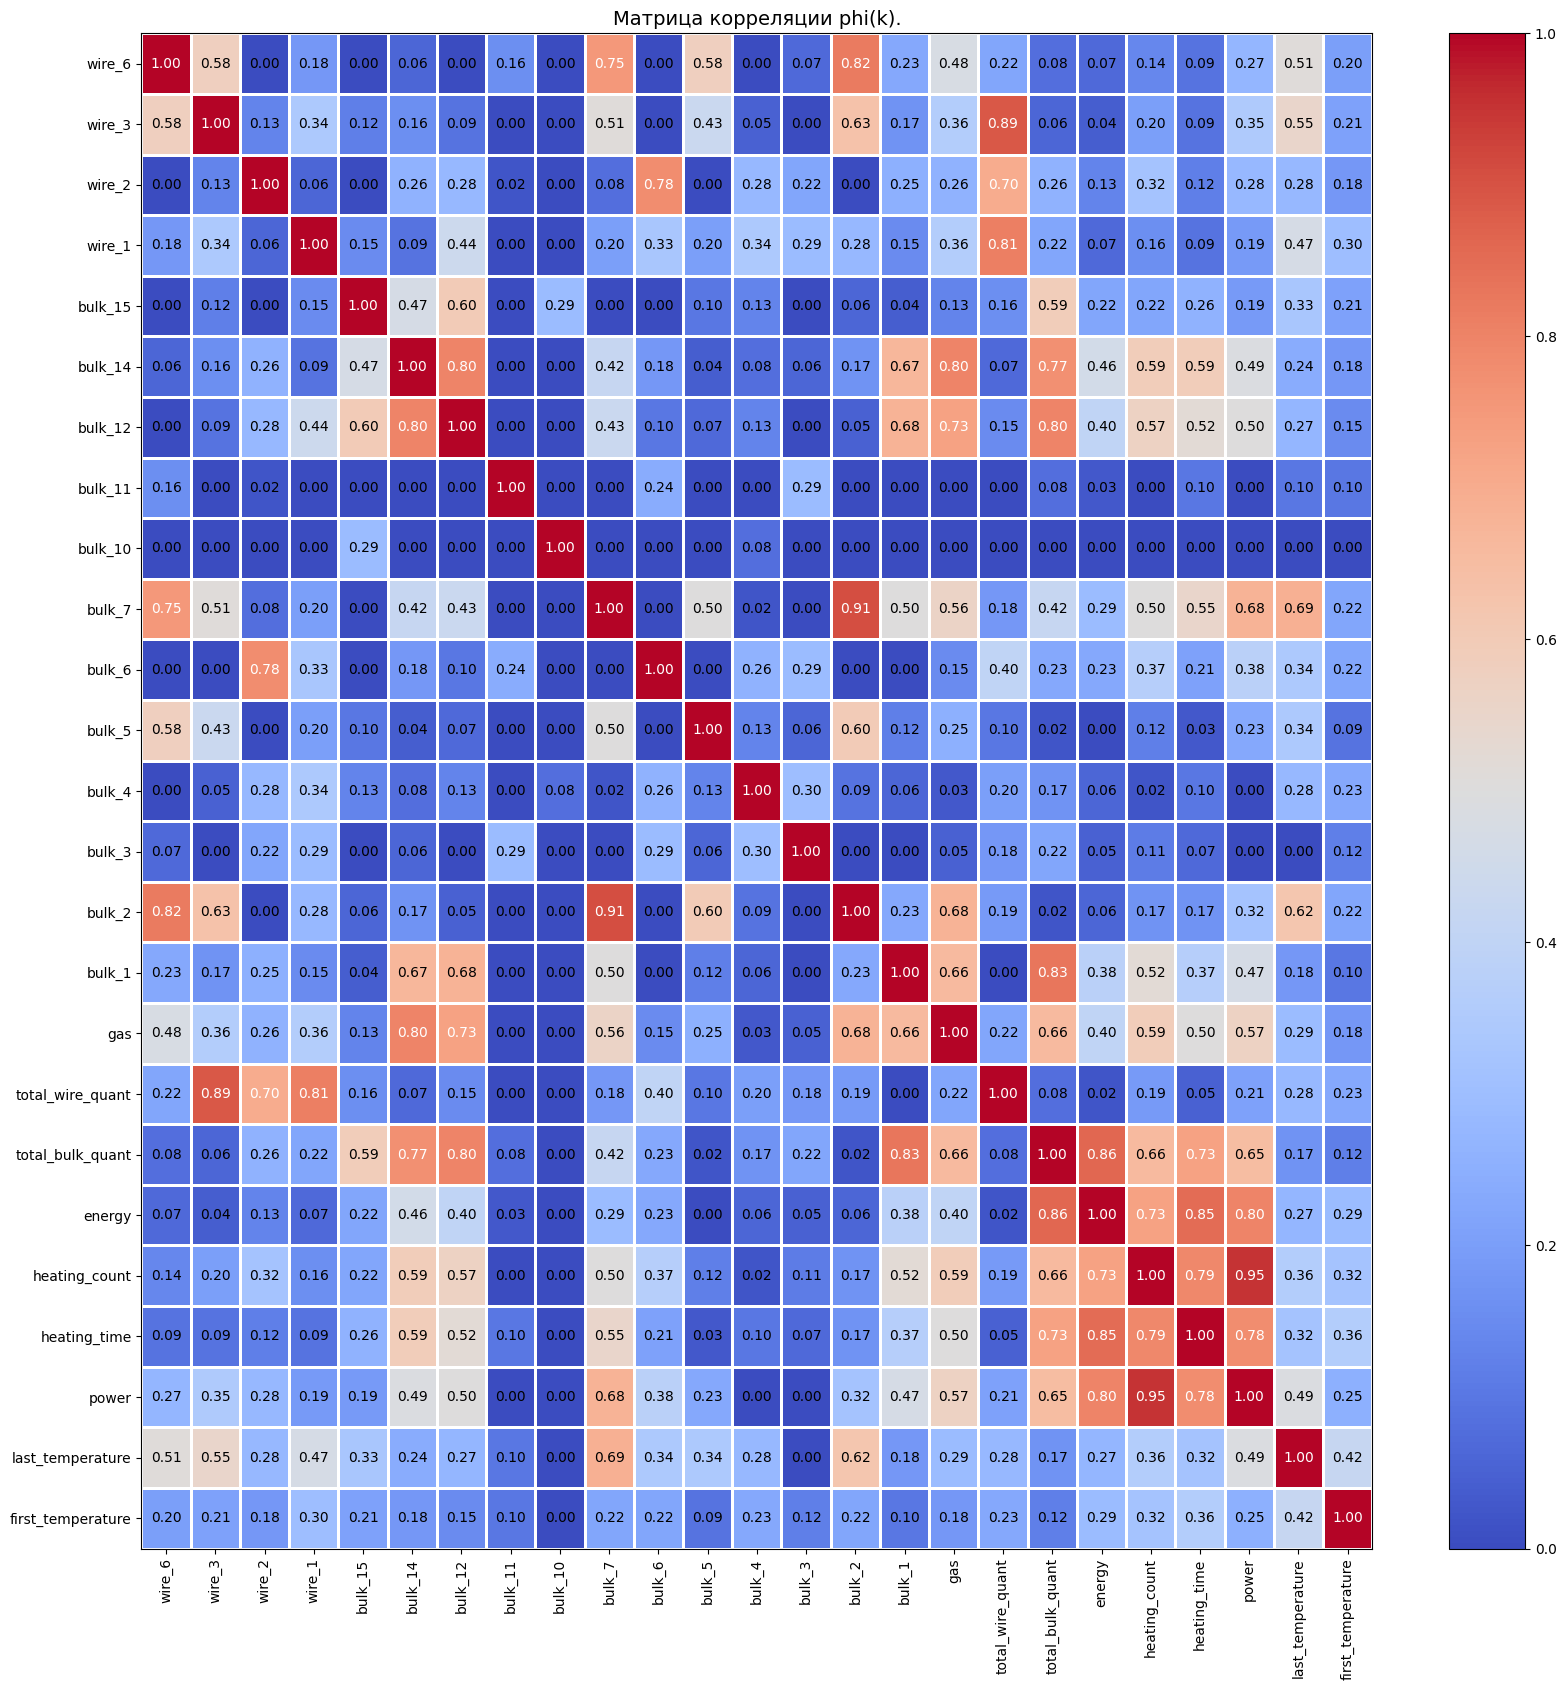

In [73]:

phik_date = train_test_df.phik_matrix().round(2)

plot_correlation_matrix(phik_date.values, 
                        x_labels = phik_date.columns, 
                        y_labels = phik_date.index, 
                        vmin = 0, vmax = 1, color_map = "coolwarm", 
                        title = 'Матрица корреляции phi(k).', 
                        fontsize_factor = 1, 
                        figsize = (17, 17));
plt.tight_layout()
plt.show()

### Выводы

* При формировании итогового датафрейма `train_test_df`, из-за ономально низких значений исключены из общего списка следующие признаки:
    * `bulk_8`, `bulk_9`, `bulk_13`,
    * `wire_4`, `wire_5`, `wire_7`, `wire_8`, `wire_9`
* Корреляционный анализ указывает на мультиколлинеарность признаков: `active_power` и `reactive_power` - оба признака удалены, есть признак `power`.
* После удаления `active_power` и `reactive_power` признаков мультиколлинеарности не обнаружено

## Информация о финальном датафрейме, на котором будут обучаться и тестироваться модели

In [74]:
train_test_df.name = 'train_test_df'
duplicates_df, train_test_df__original_shape = df_inf(train_test_df, head_row = 3, drop_duplicates_flag = False)

 ________________________________________________________________________________________ 
 Имя датафрейма: train_test_df 
 ________________________________________________________________________________________ 

 train_test_df (первые 3 строк) 


,first_temperature,last_temperature,power,heating_time,heating_count,energy,total_bulk_quant,total_wire_quant,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6
key,,,,,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,3.718736,1098,5,770.282114,553,60,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.0,0.0,0.0
2,1581,1602,2.588349,811,4,481.760005,582,96,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.0,0.0,0.0
3,1596,1599,5.019223,655,5,722.837668,544,91,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.0,0.0,0.0



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 2291 entries, 1 to 2499
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   first_temperature  2291 non-null   int64  
 1   last_temperature   2291 non-null   int64  
 2   power              2291 non-null   float64
 3   heating_time       2291 non-null   int64  
 4   heating_count      2291 non-null   int64  
 5   energy             2291 non-null   float64
 6   total_bulk_quant   2291 non-null   int64  
 7   total_wire_quant   2291 non-null   int64  
 8   gas                2291 non-null   float64
 9   bulk_1             2291 non-null   float64
 10  bulk_2             2291 non-null   float64
 11  bulk_3             2291 non-null   float64
 12  bulk_4             2291 non-null   float64
 13  bulk_5             2291 non-null   float64
 14  bulk_6             2291 non-null   float64
 15  bulk_7             2291 non-null   float64
 16  bulk_10      

,first_temperature,last_temperature,power,heating_time,heating_count,energy,total_bulk_quant,total_wire_quant,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6
count,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000
mean,1587.297687,1593.376691,3.888321,809.374072,4.700131,671.445477,610.859450,125.137058,11.399388,3.440856,1.446093,47.687909,37.159756,2.683981,22.535574,2.037975,5.088171,4.151462,208.787866,154.086425,120.194675,102.442658,17.726352,3.288446,0.995055
std,23.751433,11.179284,1.521089,341.289300,1.610147,320.070448,287.897095,63.948393,6.402639,12.430782,19.238904,75.564721,58.661510,22.584796,56.047655,30.928610,20.964247,22.267748,157.255122,81.593954,84.725942,43.656301,33.808897,28.170638,8.764208
min,1519.000000,1541.000000,0.331897,57.000000,1.000000,33.430208,19.000000,1.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,2.848200,585.000000,4.000000,460.645179,441.000000,88.000000,7.301535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,73.201438,0.000000,0.000000,0.000000
50%,1587.000000,1593.000000,3.771376,780.000000,5.000000,632.581456,610.000000,116.000000,10.108007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,101.075520,0.000000,0.000000,0.000000
75%,1603.000000,1598.000000,4.772037,995.500000,6.000000,844.073884,796.000000,152.000000,14.222380,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,281.500000,204.000000,204.000000,128.080681,23.141561,0.000000,0.000000
max,1660.000000,1653.000000,15.288271,4189.000000,16.000000,4546.405812,3235.000000,568.000000,77.995040,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,159.000000,313.000000,1849.000000,636.000000,405.000000,330.314424,282.780152,385.008668,180.454575



 Описание не числовых полей:  
 Не числовых полей нет! 

 Пропуски:  


first_temperature    0
last_temperature     0
power                0
heating_time         0
heating_count        0
energy               0
total_bulk_quant     0
total_wire_quant     0
gas                  0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_14              0
bulk_15              0
wire_1               0
wire_2               0
wire_3               0
wire_6               0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 


## Распределение данных в финальном датафрейме

_____________________________________________________________________________________________________________________________
 
 Поле : first_temperature - first_temperature 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean     1587.297687
std        23.751433
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: first_temperature, dtype: float64


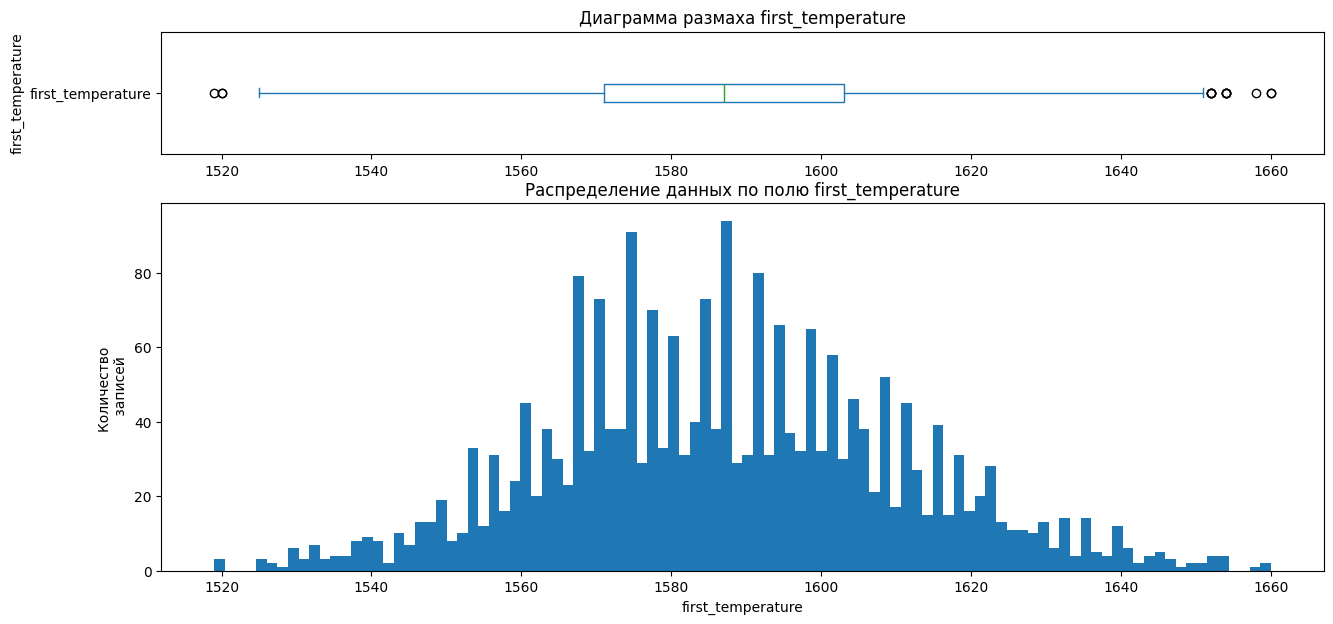

_____________________________________________________________________________________________________________________________
 
 Поле : last_temperature - last_temperature 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean     1593.376691
std        11.179284
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: last_temperature, dtype: float64


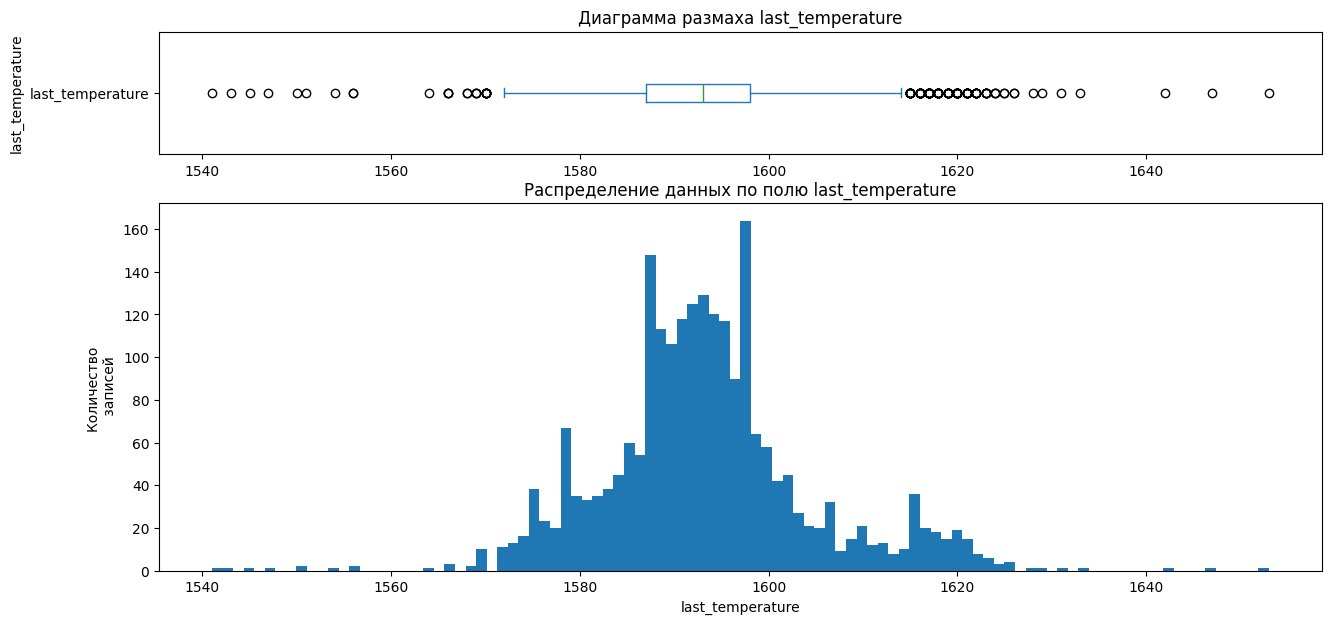

_____________________________________________________________________________________________________________________________
 
 Поле : power - power 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        3.888321
std         1.521089
min         0.331897
25%         2.848200
50%         3.771376
75%         4.772037
max        15.288271
Name: power, dtype: float64


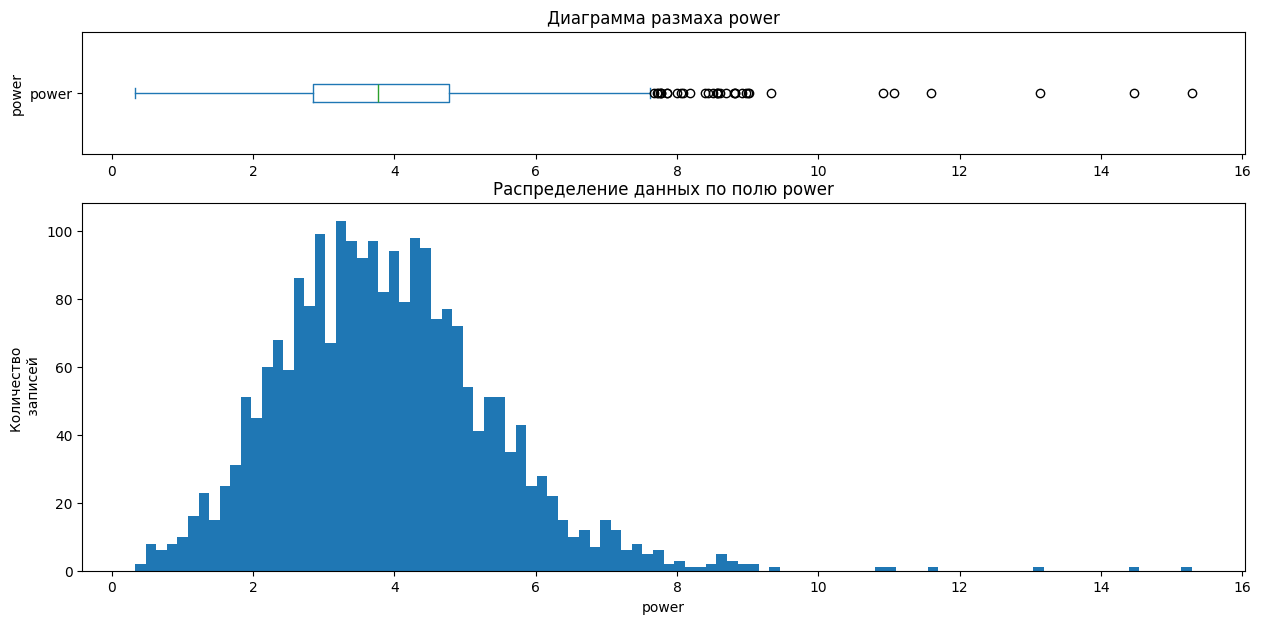

_____________________________________________________________________________________________________________________________
 
 Поле : heating_time - heating_time 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean      809.374072
std       341.289300
min        57.000000
25%       585.000000
50%       780.000000
75%       995.500000
max      4189.000000
Name: heating_time, dtype: float64


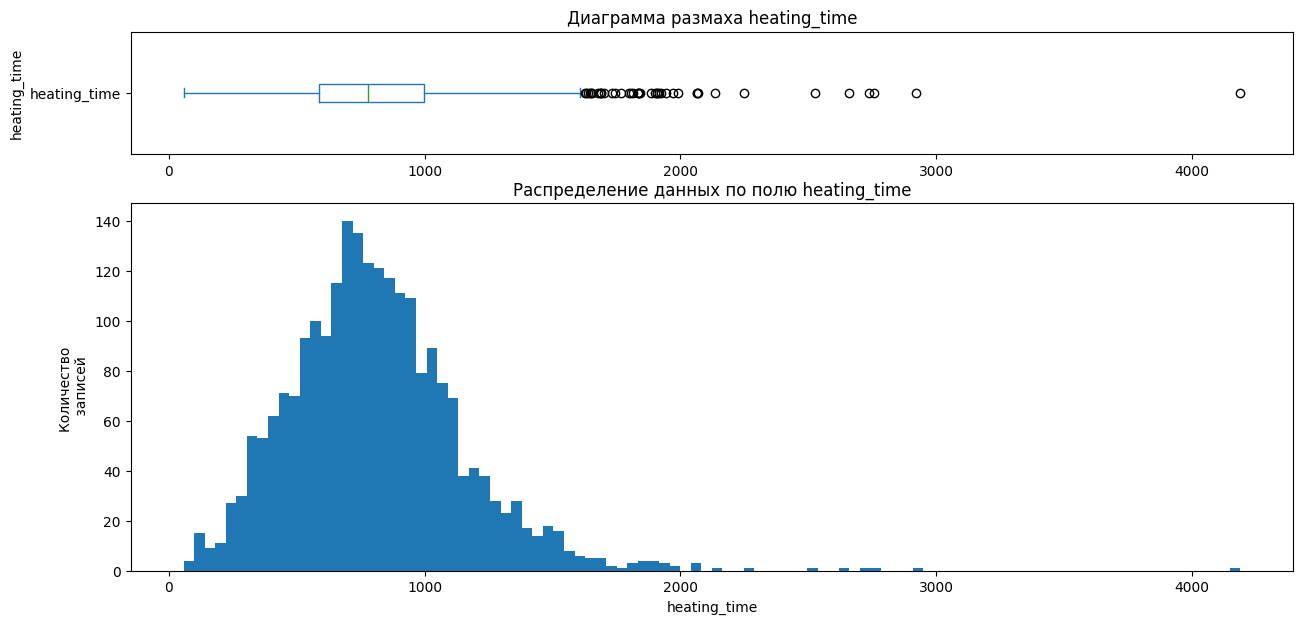

_____________________________________________________________________________________________________________________________
 
 Поле : heating_count - heating_count 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        4.700131
std         1.610147
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: heating_count, dtype: float64


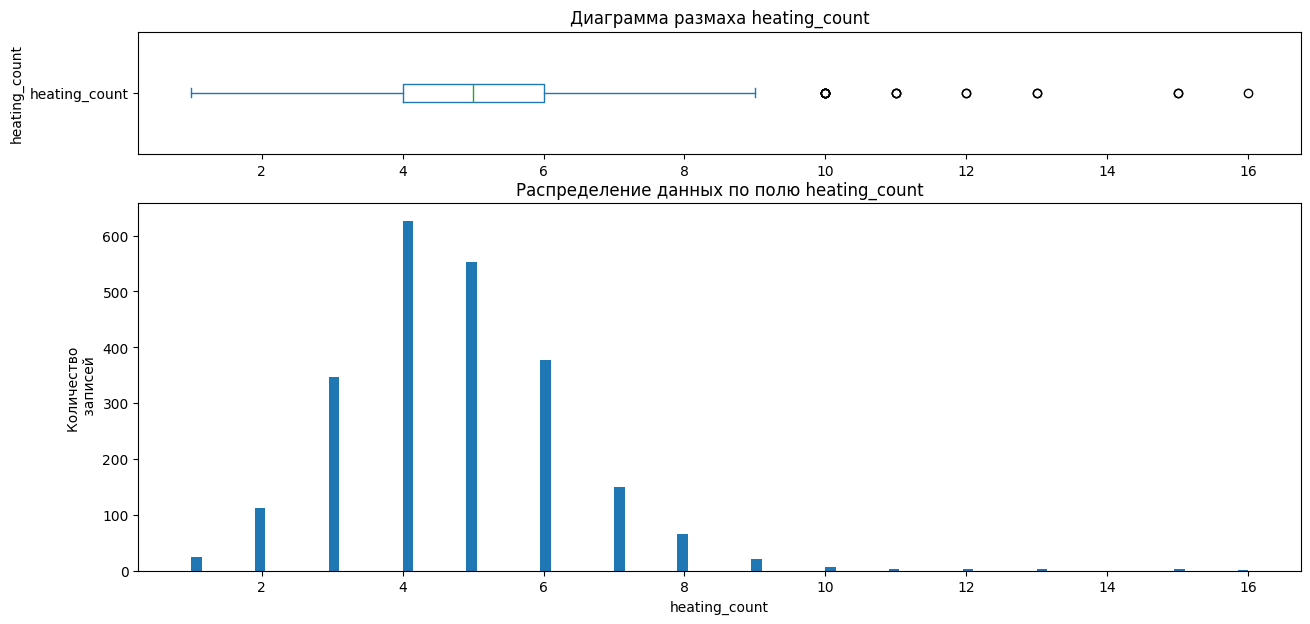

_____________________________________________________________________________________________________________________________
 
 Поле : energy - energy 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean      671.445477
std       320.070448
min        33.430208
25%       460.645179
50%       632.581456
75%       844.073884
max      4546.405812
Name: energy, dtype: float64


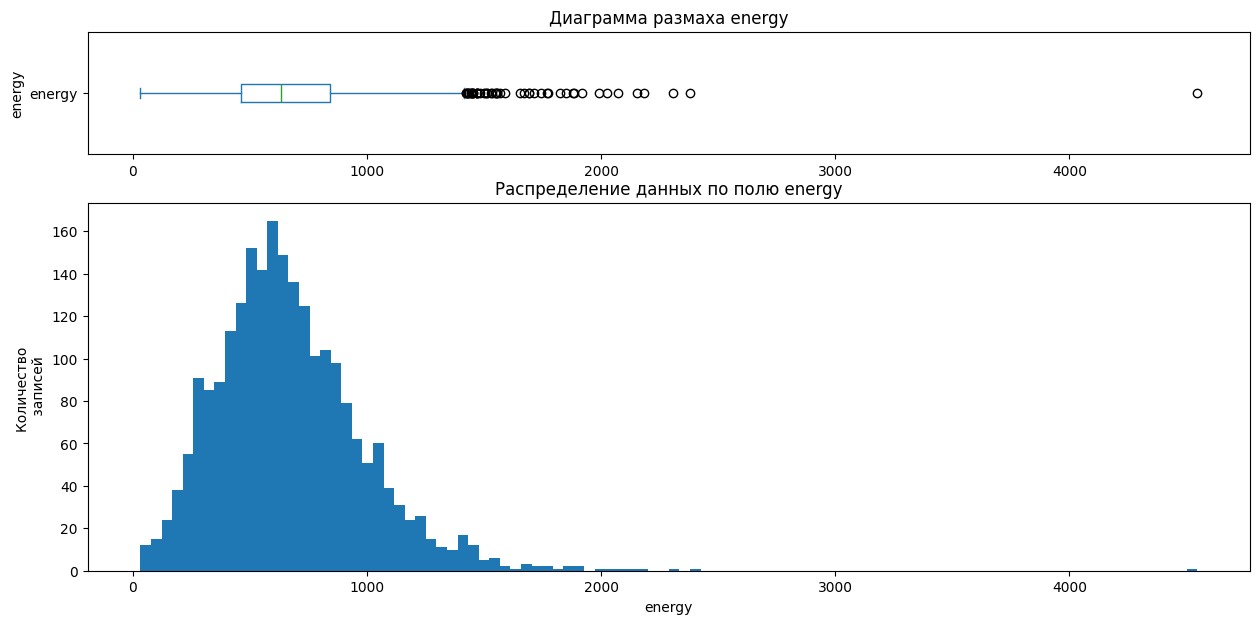

_____________________________________________________________________________________________________________________________
 
 Поле : total_bulk_quant - total_bulk_quant 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean      610.859450
std       287.897095
min        19.000000
25%       441.000000
50%       610.000000
75%       796.000000
max      3235.000000
Name: total_bulk_quant, dtype: float64


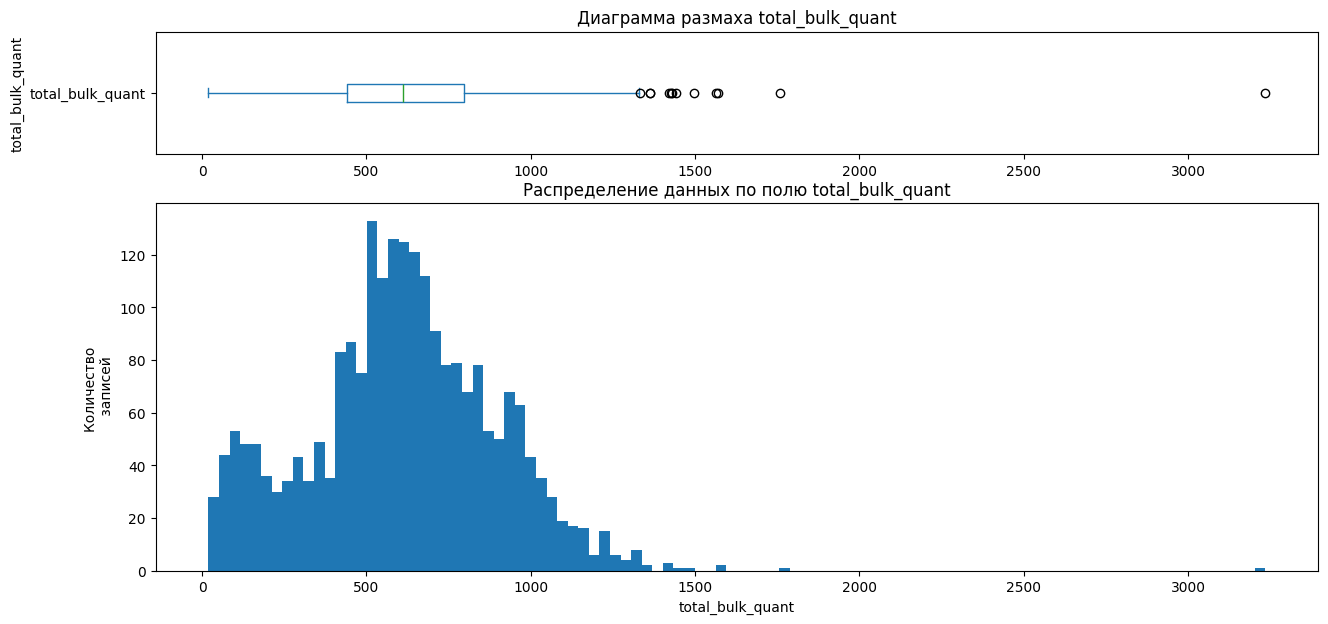

_____________________________________________________________________________________________________________________________
 
 Поле : total_wire_quant - total_wire_quant 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean      125.137058
std        63.948393
min         1.000000
25%        88.000000
50%       116.000000
75%       152.000000
max       568.000000
Name: total_wire_quant, dtype: float64


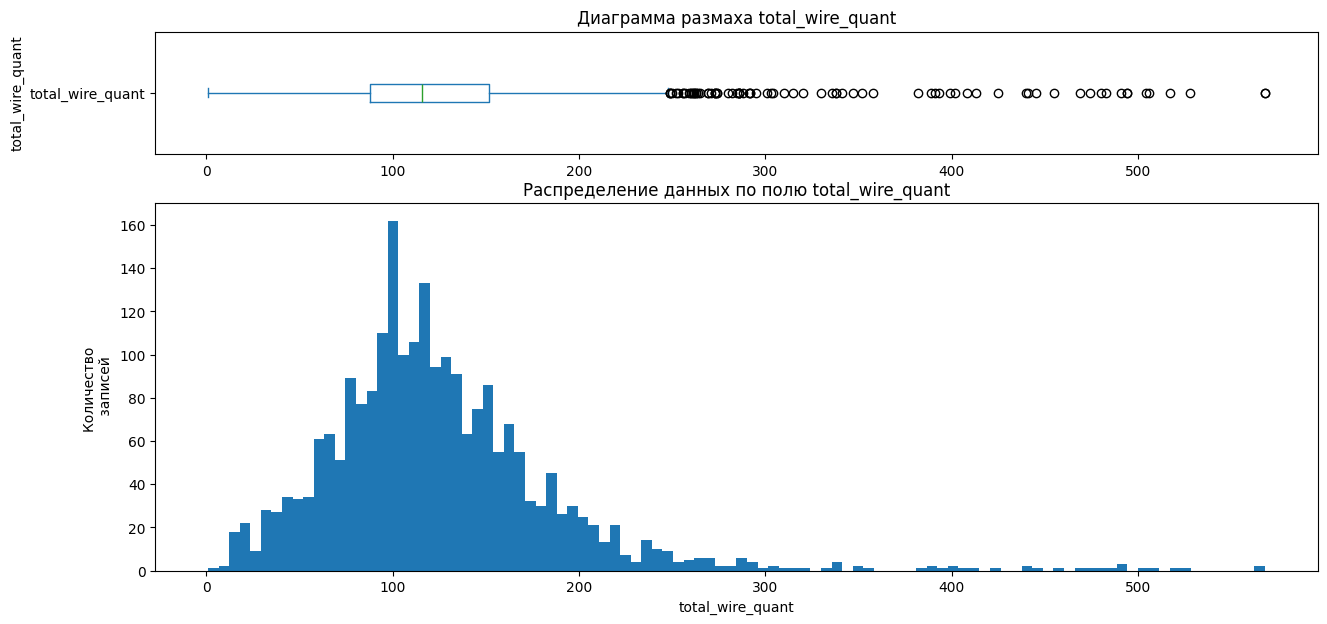

_____________________________________________________________________________________________________________________________
 
 Поле : gas - gas 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean       11.399388
std         6.402639
min         0.008399
25%         7.301535
50%        10.108007
75%        14.222380
max        77.995040
Name: gas, dtype: float64


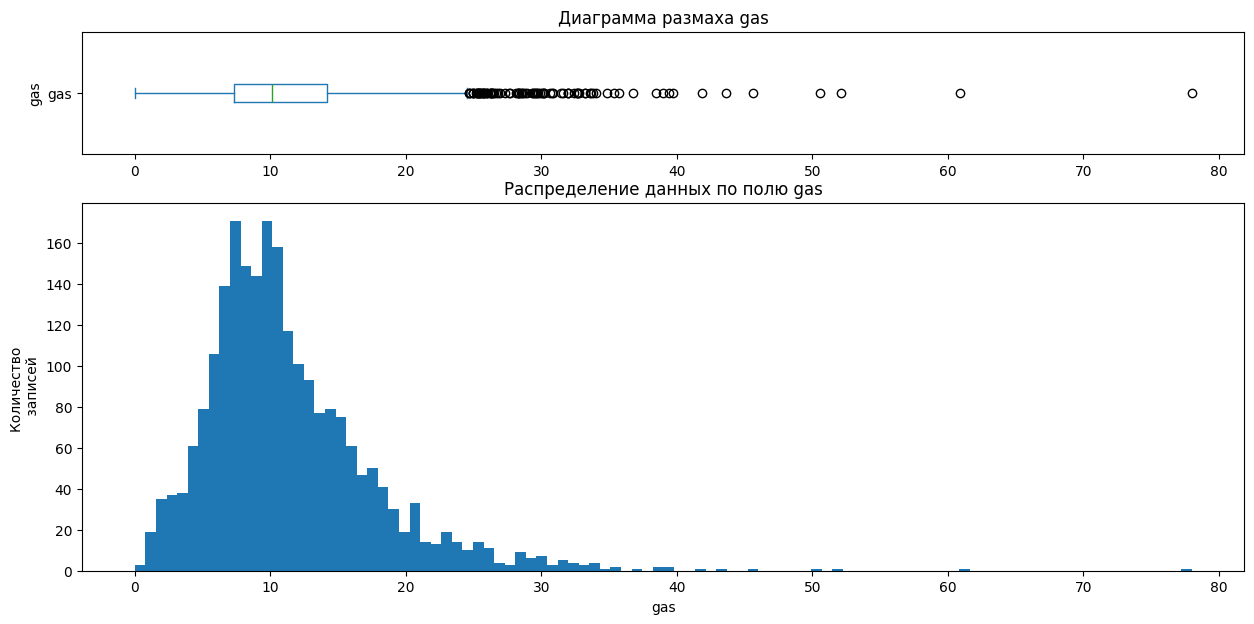

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_1 - bulk_1 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        3.440856
std        12.430782
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: bulk_1, dtype: float64


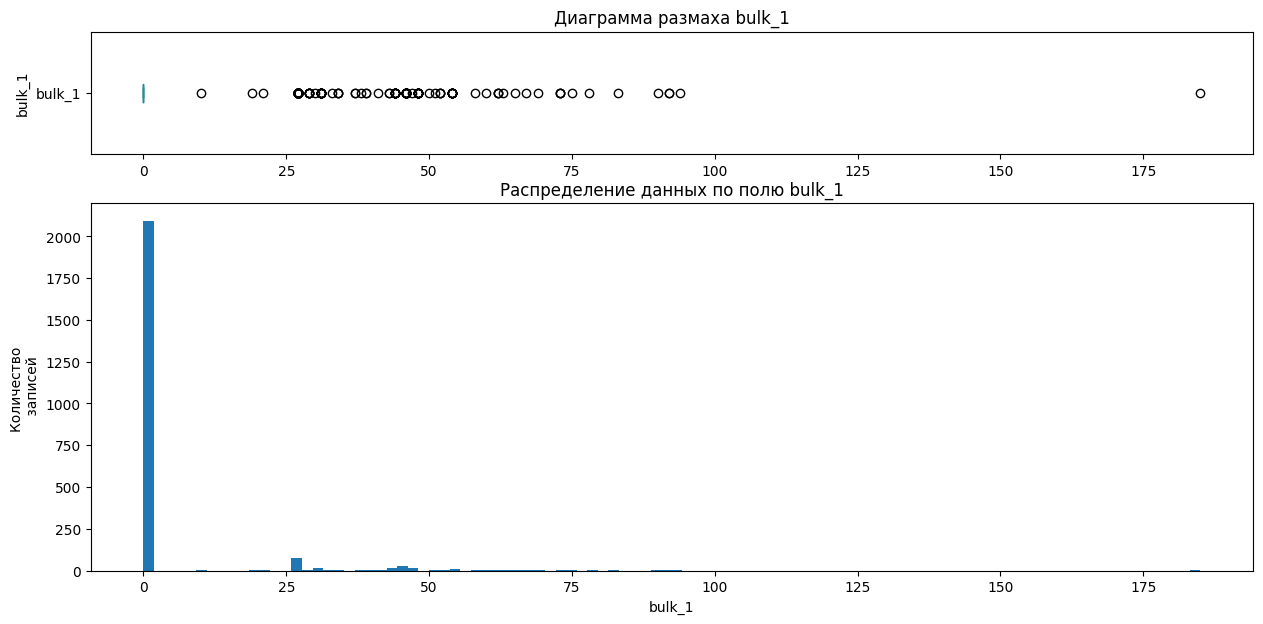

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_2 - bulk_2 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        1.446093
std        19.238904
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: bulk_2, dtype: float64


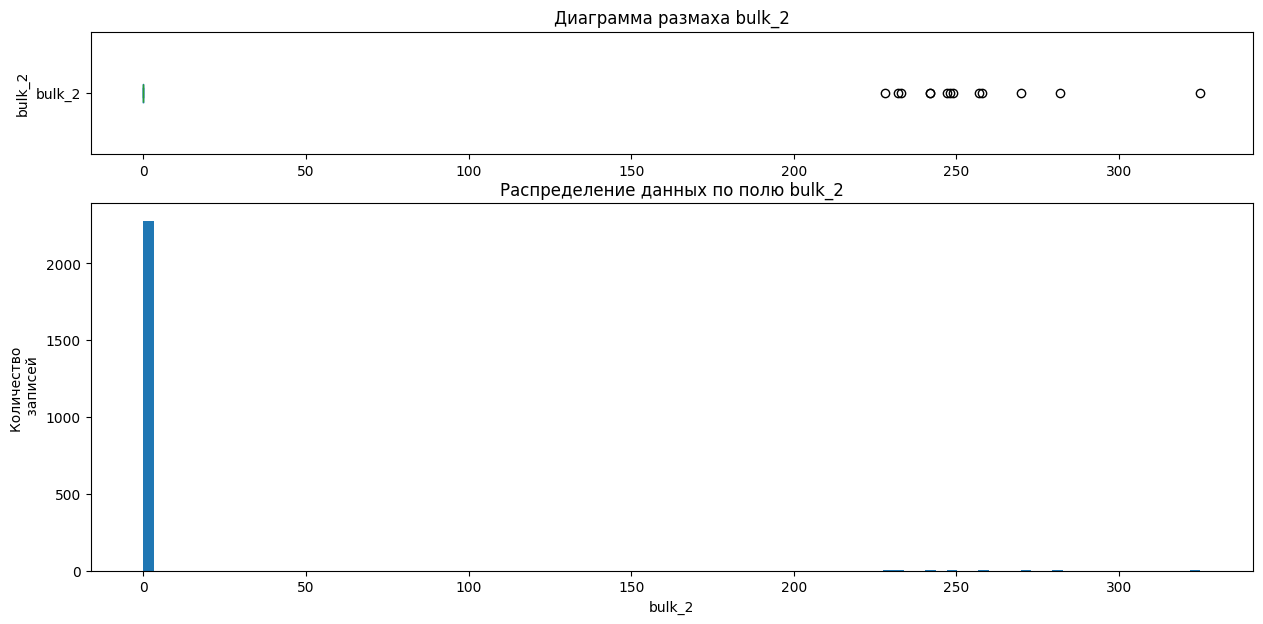

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_3 - bulk_3 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean       47.687909
std        75.564721
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64


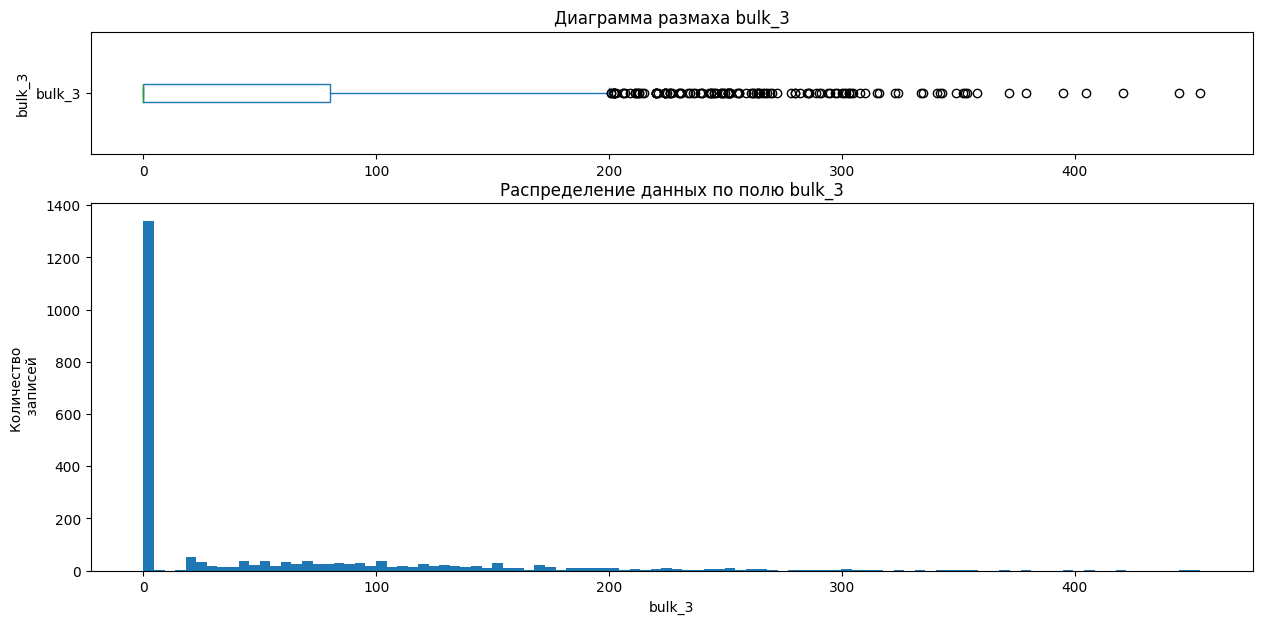

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_4 - bulk_4 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean       37.159756
std        58.661510
min         0.000000
25%         0.000000
50%         0.000000
75%        77.000000
max       281.000000
Name: bulk_4, dtype: float64


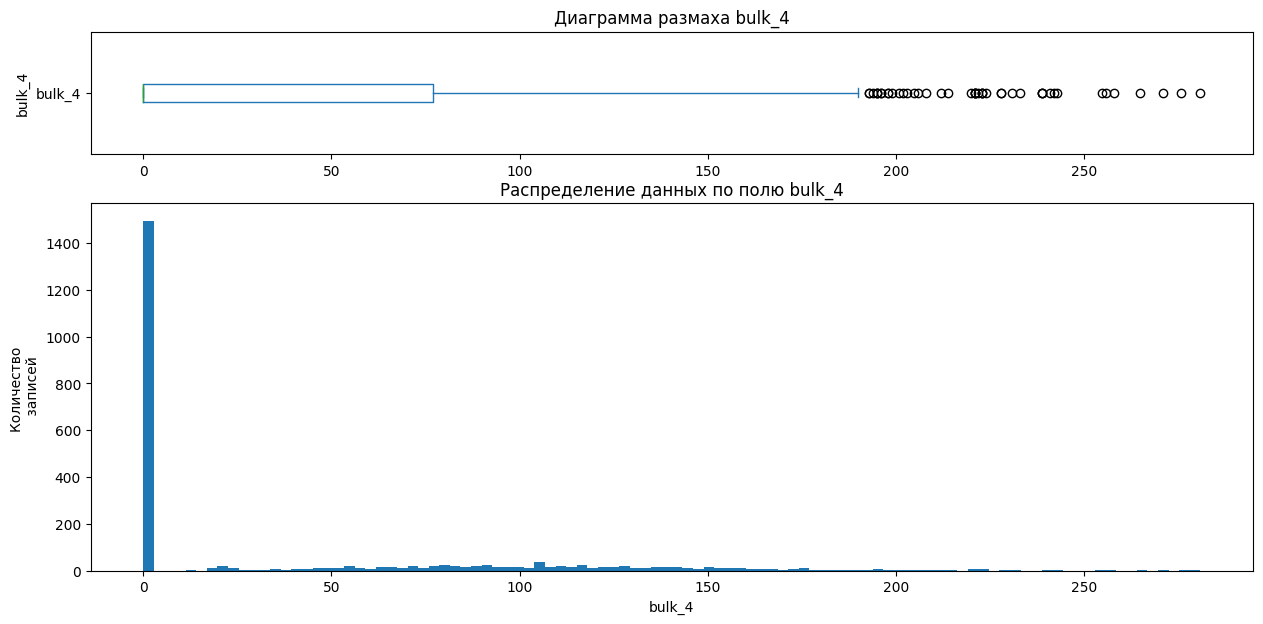

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_5 - bulk_5 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        2.683981
std        22.584796
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: bulk_5, dtype: float64


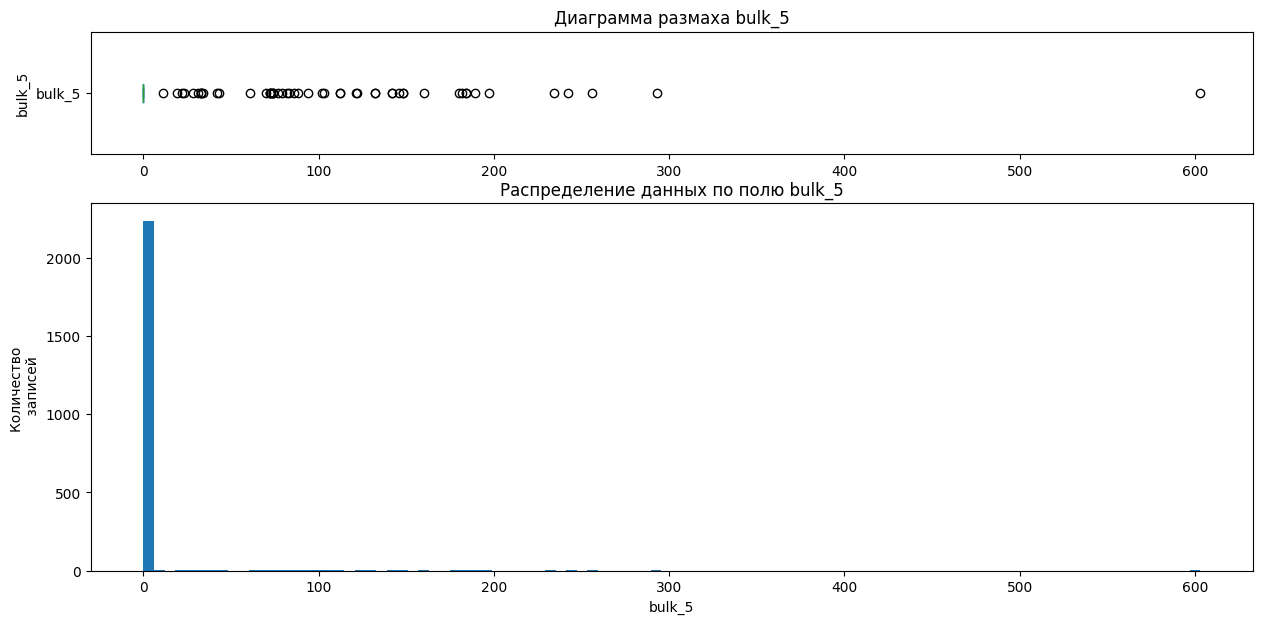

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_6 - bulk_6 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean       22.535574
std        56.047655
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: bulk_6, dtype: float64


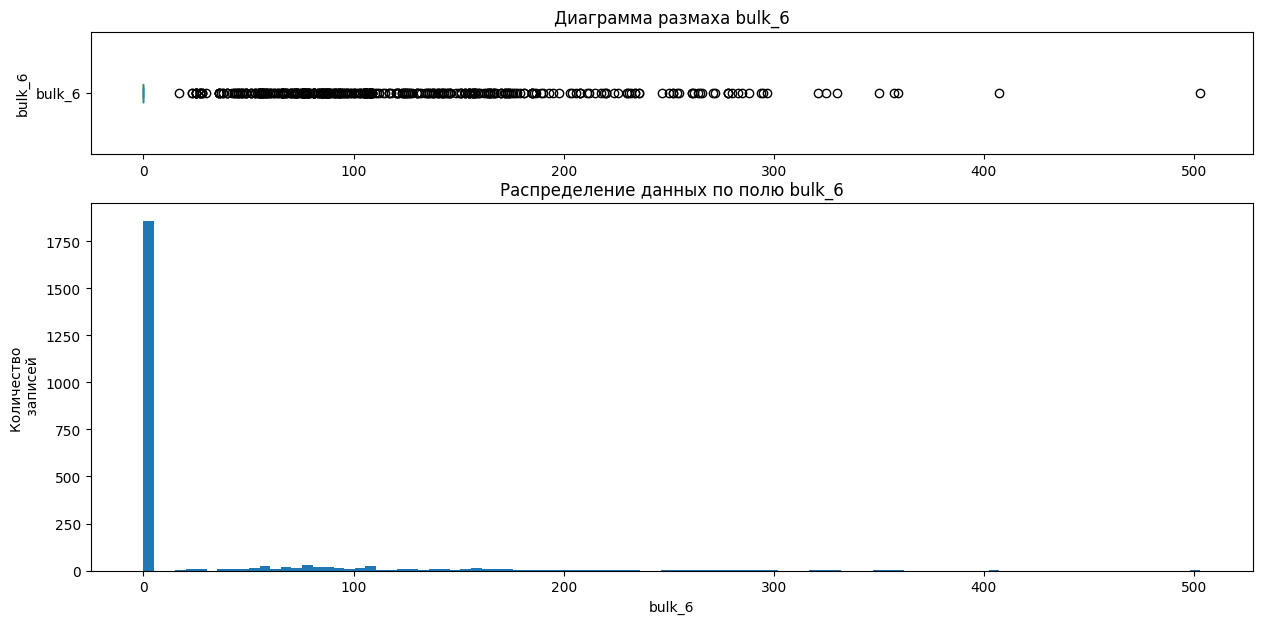

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_7 - bulk_7 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        2.037975
std        30.928610
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: bulk_7, dtype: float64


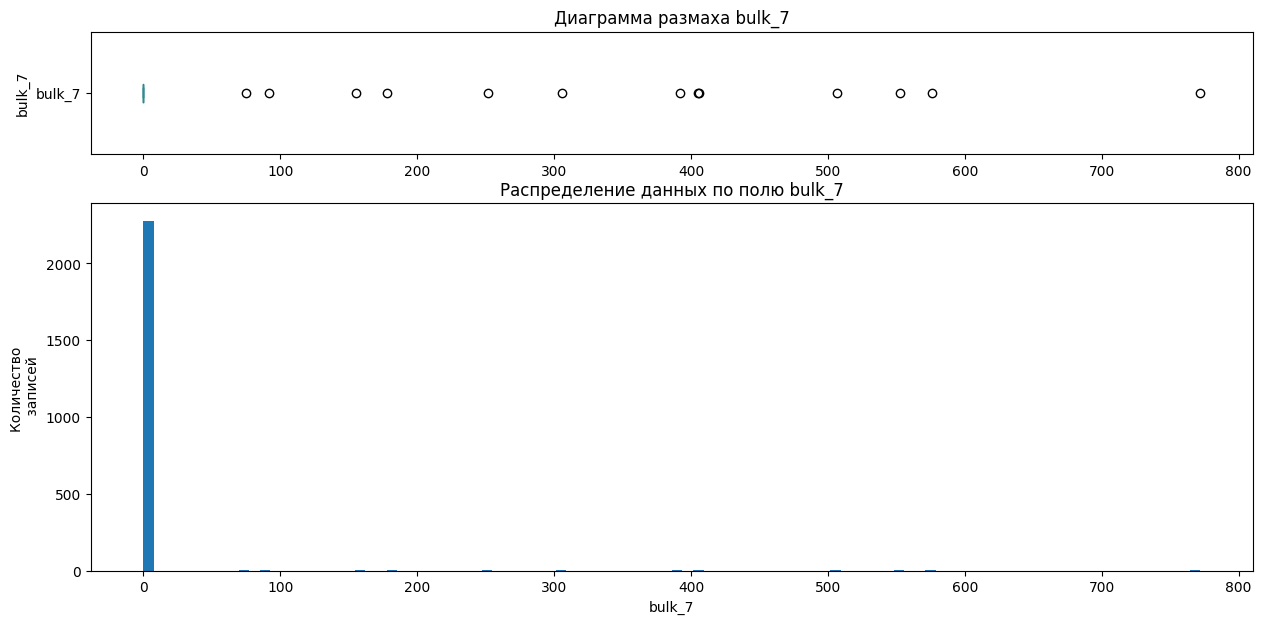

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_10 - bulk_10 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        5.088171
std        20.964247
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: bulk_10, dtype: float64


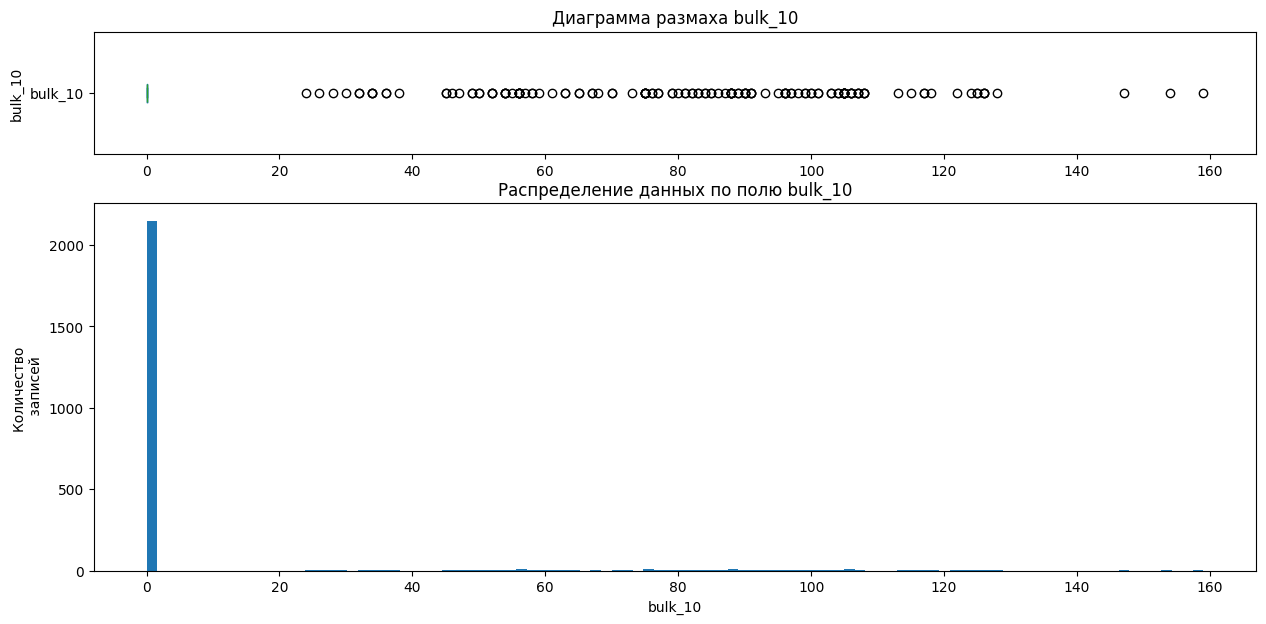

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_11 - bulk_11 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        4.151462
std        22.267748
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: bulk_11, dtype: float64


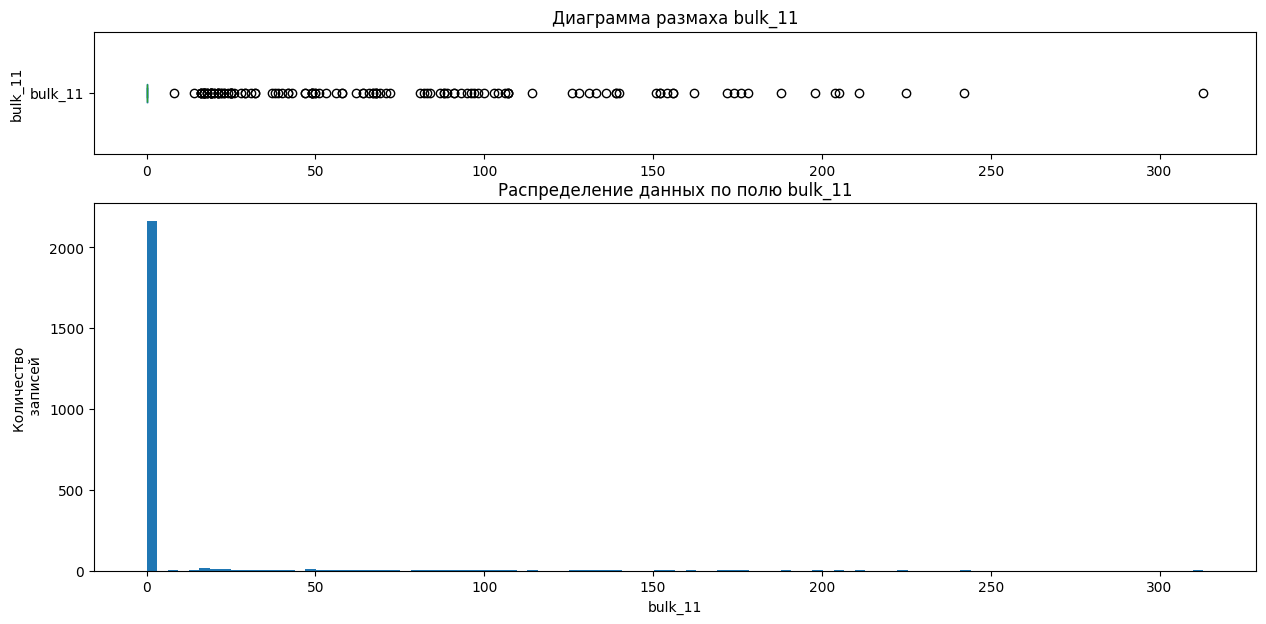

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_12 - bulk_12 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean      208.787866
std       157.255122
min         0.000000
25%       105.000000
50%       206.000000
75%       281.500000
max      1849.000000
Name: bulk_12, dtype: float64


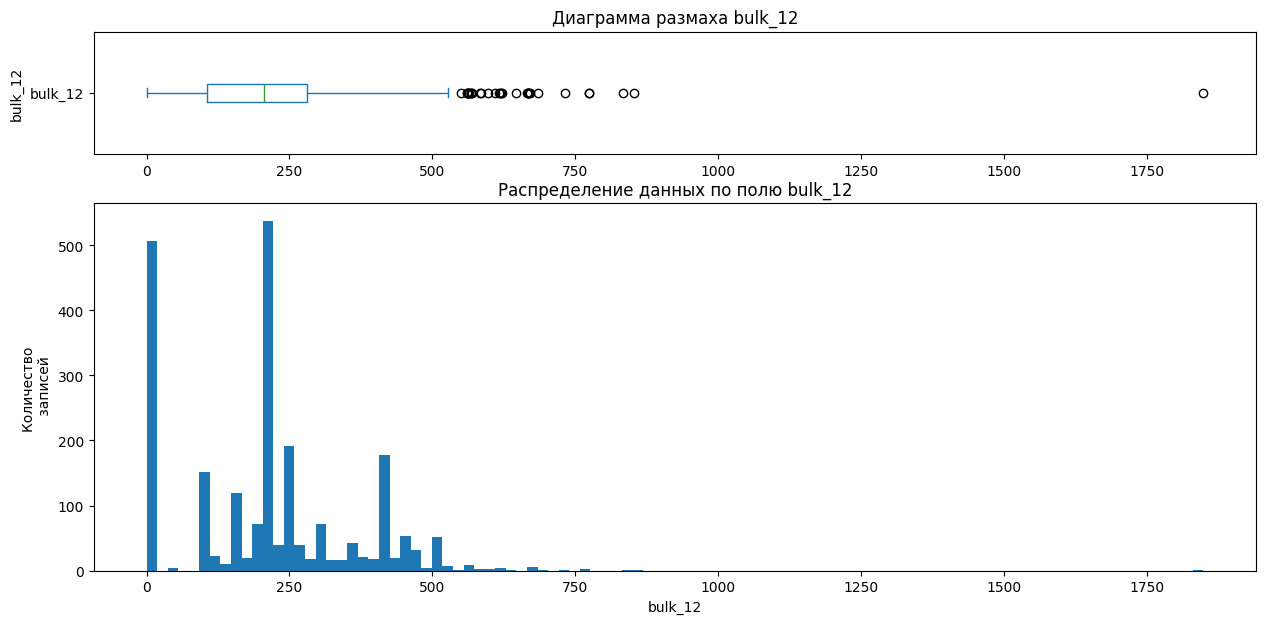

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_14 - bulk_14 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean      154.086425
std        81.593954
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: bulk_14, dtype: float64


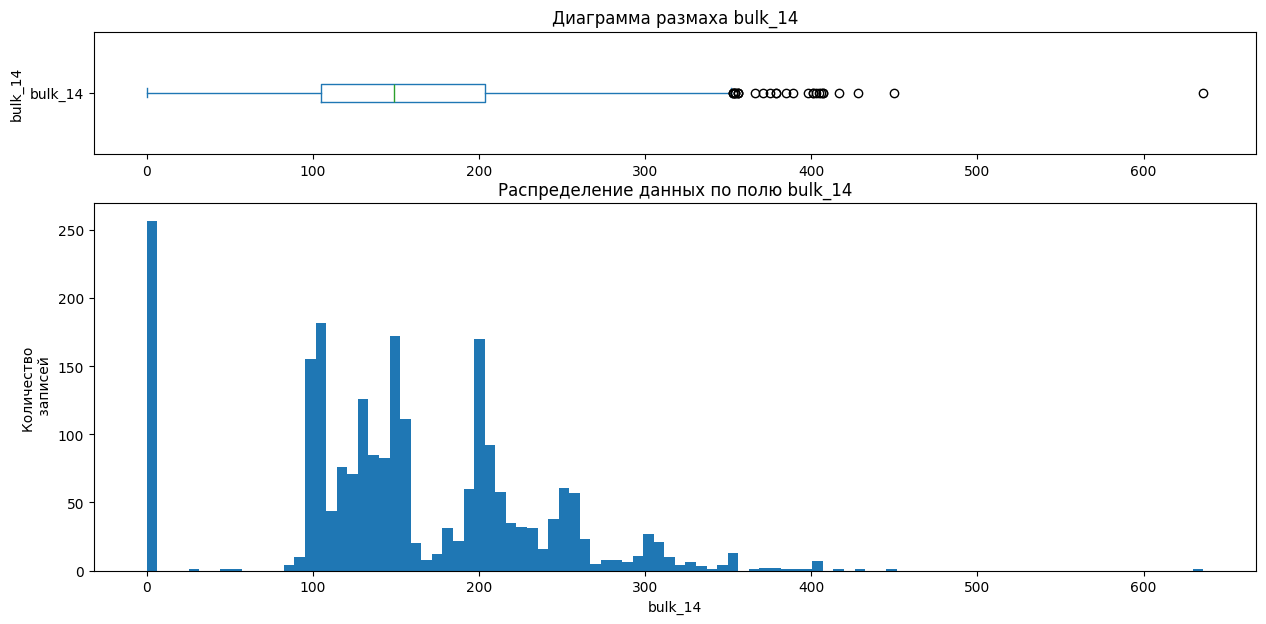

_____________________________________________________________________________________________________________________________
 
 Поле : bulk_15 - bulk_15 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean      120.194675
std        84.725942
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64


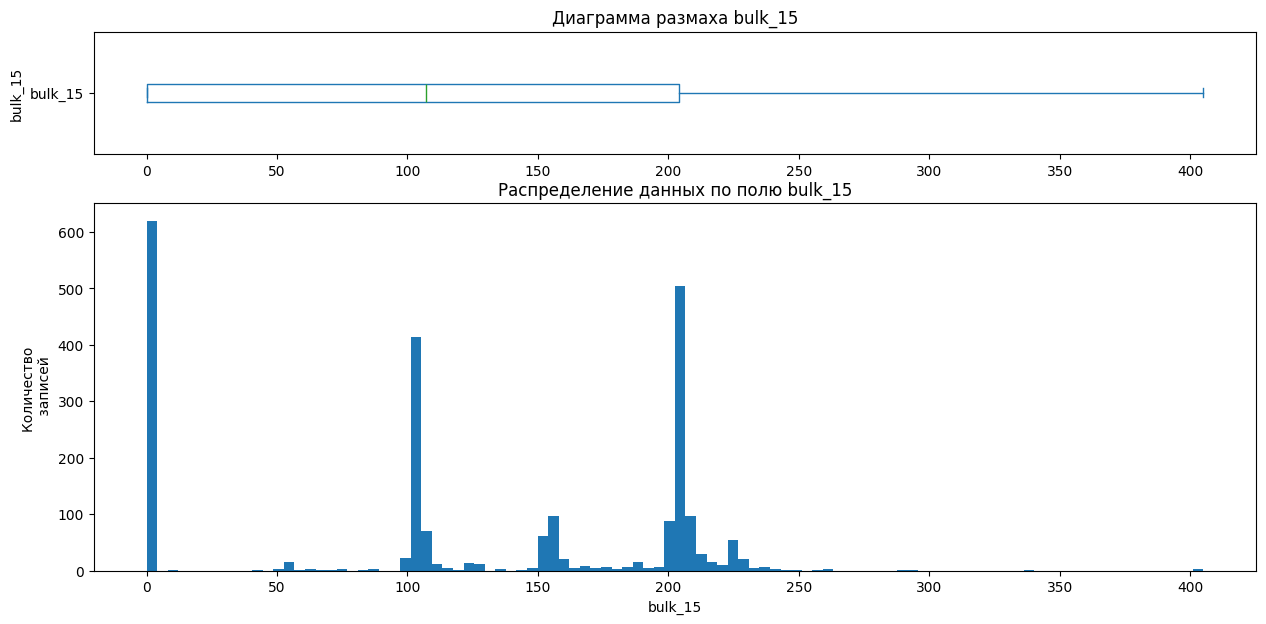

_____________________________________________________________________________________________________________________________
 
 Поле : wire_1 - wire_1 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean      102.442658
std        43.656301
min         0.000000
25%        73.201438
50%       101.075520
75%       128.080681
max       330.314424
Name: wire_1, dtype: float64


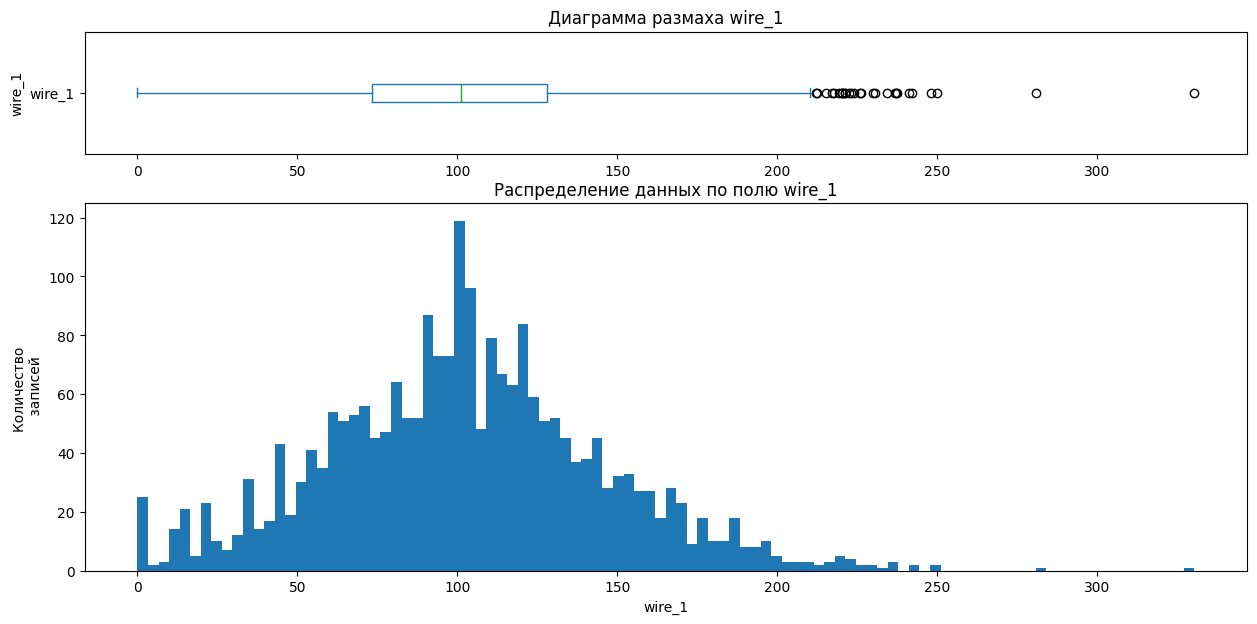

_____________________________________________________________________________________________________________________________
 
 Поле : wire_2 - wire_2 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean       17.726352
std        33.808897
min         0.000000
25%         0.000000
50%         0.000000
75%        23.141561
max       282.780152
Name: wire_2, dtype: float64


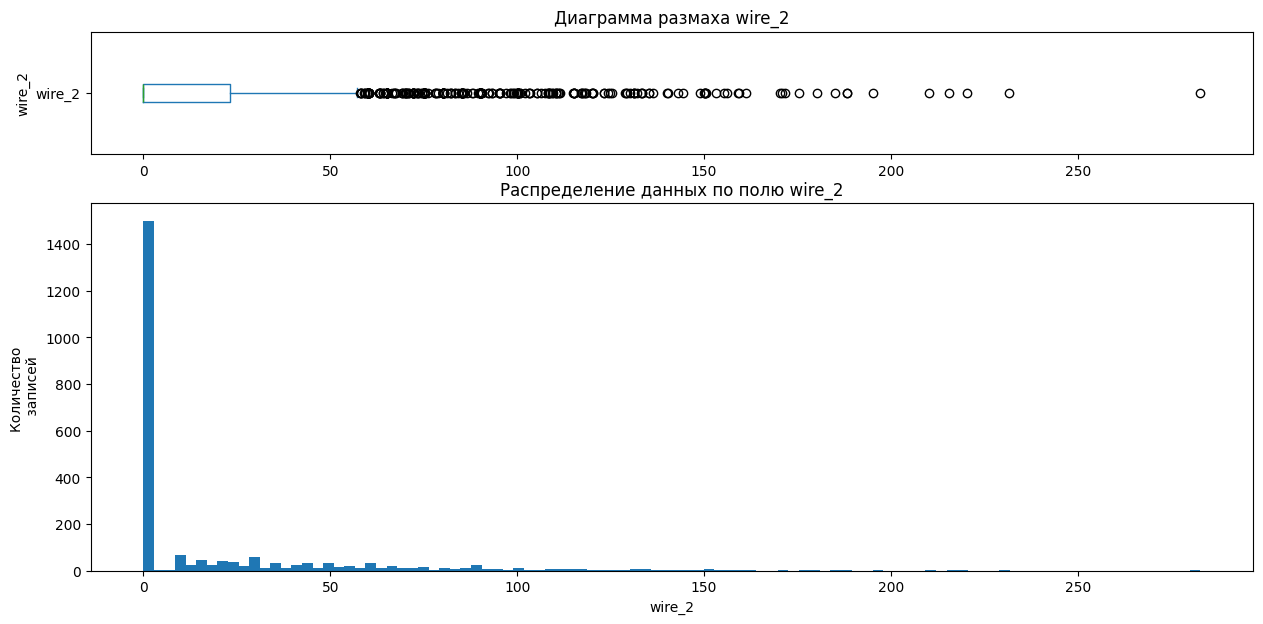

_____________________________________________________________________________________________________________________________
 
 Поле : wire_3 - wire_3 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        3.288446
std        28.170638
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: wire_3, dtype: float64


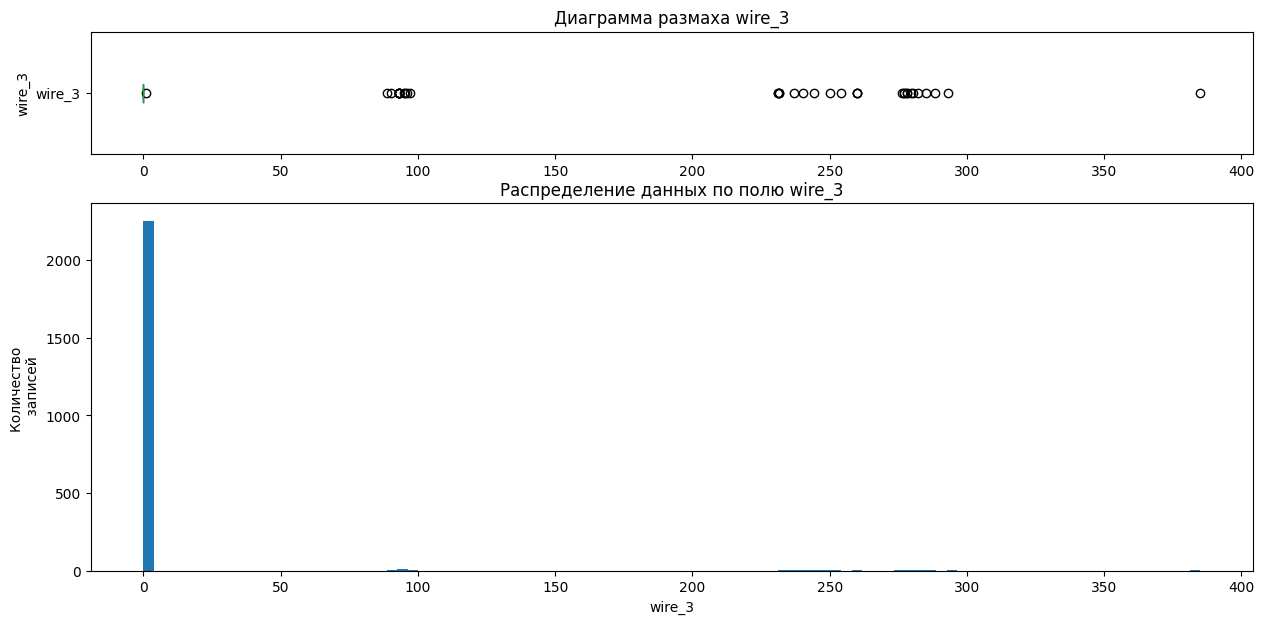

_____________________________________________________________________________________________________________________________
 
 Поле : wire_6 - wire_6 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    2291.000000
mean        0.995055
std         8.764208
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: wire_6, dtype: float64


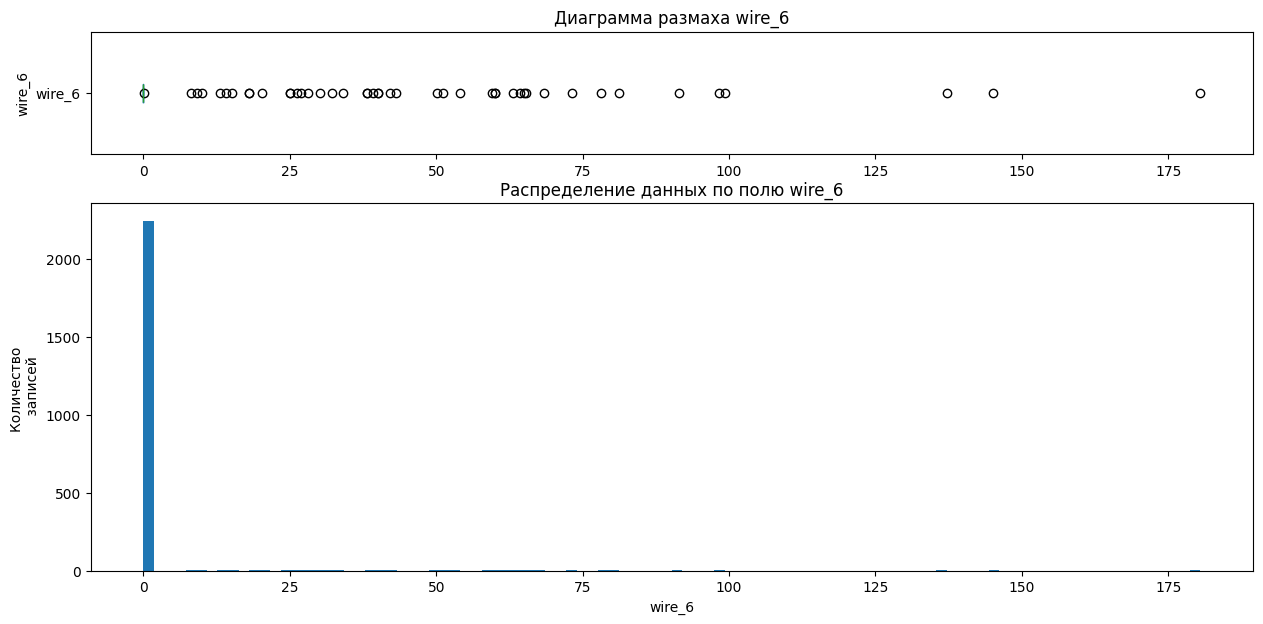

In [75]:
for current_field in train_test_df.columns:
    # print(current_df[current_field].dtypes)
        
    box_plot_title = 'Диаграмма размаха ' + current_field
    hist_title = 'Распределение данных по полю ' + current_field

    column_analiser(
        train_test_df,
        current_field,
        x_label = current_field,
        y_label = 'Количество \n записей',
                
        box_plot_title = [box_plot_title],
        hist_title = [hist_title],
        print_unique = False,
        bins_= 100,
        figsize_ = (15, 7),
        height_ratios_ = [1, 3],
        hue_lst_ = [],
        kde_plot_log_flag_ = False,
        kde_plot_figsize_ = (15, 4),
        kde_plot_title = '',
        kde_plot_x_label = '',
        kde_plot_y_label = '')


## Определение входящих и целевого признаков

In [76]:
X = train_test_df.drop('last_temperature', axis = 1)
y = train_test_df['last_temperature']

In [77]:
print(X.shape)
print(y.shape)

(2291, 24)
(2291,)


## Разделение на обучающую и тестовую выборки

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_STATE)

In [79]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1718, 24)
(1718,)
(573, 24)
(573,)


## Удаление аномалий признака `heating_time` из обучающей выборки

In [80]:
# Удаление выбрасов из X_train и y_train
X_train['target'] = y_train
X_train = X_train.loc[X_train['heating_time'] <= 4000]

y_train = X_train['target']
X_train = X_train.drop('target', axis = 1)

In [81]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1717, 24)
(1717,)
(573, 24)
(573,)


## **`Выводы`**

* сформирован дытафрейм `train_test_df`, содержащий объединенную агрегированную информацию по полю `key` (одна запись `train_test_df` содержит всю информацию о наблюдении для обучения и тестирования моделей)
* `train_test_df` содержащий информацию о `2290` наблюдениях
* Признаки включенные в `train_test_df`
    * `first_temperature` - температура первого нагрева
    * `last_temperature` - температура последнего нагрева
    * `heating_time` - время нагрева
    * `heating_count` - количество нагревов
    * `bulk_1, bulk_2, bulk_3, bulk_4, bulk_5, bulk_6, bulk_7, bulk_10, bulk_11, bulk_12, bulk_14, bulk_15` - количество сыпучих материалов
    * `total_bulk_quant` - общее количество сыпучих материалов
    * `wire_1, wire_2, wire_3, wire_6`  - количество проволочных материалов
    * `total_wire_quant` - общее количество проволочных материалов
    * `energy` - расход электроэнергии
    * `power` - общая мощность
    * `gas` - объем используемого газа
* В соответствии с требованиями проекта определен **целевой признак** - **`last_temperature`** - температура последнего замера
* Реализовано разделение на выборки в соотношении `0.75 (обучающая)` и `0.25 (тестовая)`

# Обучение моделей

## Построение нейронной сети

### Формирование тензоров по выборкам

In [82]:
X_train_torch = torch.FloatTensor(X_train.values)
X_test_torch = torch.FloatTensor(X_test.values)

y_train_torch = torch.FloatTensor(y_train.values) #
y_test_torch = torch.FloatTensor(y_test.values) #

### Определение параметров и формирование экземпляра класса модели

In [83]:
# Количество входящих нейронов = количеству входящих признаков
N_IN_NEURONS = X_train_torch.size(1) 

# Количество нейронов первого уровня
N_HIDDEN_NEURONS_1 = 30 #50

# Количество нейронов второго уровня
N_HIDDEN_NEURONS_2 = 10 #20

# Количество выходных нейронов
N_OUT_NEURONS = 1

# Функция потерь
LOSS = nn.L1Loss()

# Количество эпох
EPOCHS_COUNT = 50 #250

# Список значений размеров батча
BATCH_SIZE = [3, 6] # 12, 24

# Количество итераций обучения
OPTIMAZE_ITTERATION_COUNT = 3

# формирование объекта класса Model
net = Model(
    N_IN_NEURONS,
    N_HIDDEN_NEURONS_1,
    N_HIDDEN_NEURONS_2,
    N_OUT_NEURONS,
    normalization_flag = False
           )

### Кросс-валидация

In [84]:
%%time
# Формирование списка оптимизаторов для net-модели
OPTIMIZER_LST = get_optimizer_lst(net)

# Результаты процесса перебора параметров сохраняется в scores
scores = cross_val_run(
    net,
    X_train_torch,
    y_train_torch,
    optimazer_lst = OPTIMIZER_LST,
    bach_size = BATCH_SIZE,
    epochs_count = EPOCHS_COUNT,
    optimize_iteration_count = OPTIMAZE_ITTERATION_COUNT,
    loss = LOSS)

 ______________________________________________________________________ 
 Оптимизатор -  


RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  значение метрики =   19.9904
     Итерация   2  значение метрики =   23.7345
     Итерация   3  значение метрики =   21.9864
 Средее значение метрики =  21.9038 

 batch_size =   6
     Итерация   1  значение метрики =   26.7179
     Итерация   2  значение метрики =   18.3567
     Итерация   3  значение метрики =   19.378
 Средее значение метрики =  21.4842 

 ______________________________________________________________________ 
 Оптимизатор -  


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  значение метрики =   23.1554
     Итерация   2  значение метрики =   31.6892
     Итерация   3  значение метрики =   27.2936
 Средее значение метрики =  27.3794 

 batch_size =   6
     Итерация   1  значение метрики =   44.4729
     Итерация   2  значение метрики =   55.8936
     Итерация   3  значение метрики =   37.173
 Средее значение метрики =  45.8465 

 ______________________________________________________________________ 
 Оптимизатор -  


Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  значение метрики =   31.2834
     Итерация   2  значение метрики =   29.8731
     Итерация   3  значение метрики =   38.7154
 Средее значение метрики =  33.2906 

 batch_size =   6
     Итерация   1  значение метрики =   33.33
     Итерация   2  значение метрики =   18.4084
     Итерация   3  значение метрики =   19.4662
 Средее значение метрики =  23.7349 

CPU times: total: 8min 44s
Wall time: 8min 30s


In [85]:
# Трансформация scores в DataFrame
scores = pd.DataFrame(scores, columns = ['optimizer_index', 'batch_size', 'MAE'])

In [86]:
# Определение лучших параметров по результатам кросс-валидации

best_optimizer_score_index, best_batch_size, best_RMCE = get_best_model_validation_params(
    scores_ = scores,
    optimazer_lst = OPTIMIZER_LST,
    metrica_field = 'MAE',
    optimizer_index_field = 'optimizer_index',
    batch_size_field = 'batch_size')

 Оптимальные параматры модели: 
     Лучший оптимайцзер -   RMSprop
     Индекс оптимизатора -   0
     Размер батча -   6
 
 Значение метрики -  21.4842 


### **`Выводы`**

* Построена сеть, содержащая два скрытых слоя, с учетом значени параметров:
    * Количество входящих нейронов = количеству входящих признаков
    * Количество нейронов первого уровня = 30
    * Количество нейронов второго уровня = 10
    * Количество выходных нейронов = 1
    * Функция потерь - `nn.L1Loss()`
    * Количество эпох = 50
    * Список значений размеров батча - 3, 6
    * Количество итераций обучения = 3
    * Список оптимизаторов - RMSprop, Adam, Adamax
* В процессе определения лучших параметров оценивались потери для каждого оптимизатора, со скоростями обучения `lr=1e-3` и `lr=1e-2` и по размерам батча, указанным в соответствующем параметре
* Результаты кросс-валидации:
    * Лучший оптимайцзер -   RMSprop
    * Р Размер батча -   3
* **MAE сети на тестовой выборке = 26.1138 . Это значение не соответствуетет требоваю к качеству модели.**

## DummyRegressor - константная модель

In [87]:
# DummyRegressor

model_dr = DummyRegressor(strategy = "mean")
model_dr.fit(X_train, y_train)
predictions = model_dr.predict(X_test)
print(blue_start, 'MAE', color_end, round(mean_absolute_error(y_test, predictions), 4))

 MAE  7.8866


## Формирование Итогового пайплайна

In [88]:
# Общий пайплайн подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), X_train.columns)
    ],
    remainder='passthrough'
)

# Итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state = RANDOM_STATE))
])

## Формирование словаря параметров для кросс-валидации - param_dist

In [89]:
# Определение параметров для поиска
param_dist = [
        {
            'models': [LGBMRegressor(verbosity=-1, random_state = RANDOM_STATE)],
            'models__n_estimators': range(10, 100, 10), #[100, 120],
            'models__max_depth': range(1, 10), #[12, 14],
            'models__learning_rate':[0.1, 0.3] #0.01, , 0.5
        },
        {
            'models': [RandomForestRegressor(random_state = RANDOM_STATE)],
            'models__n_estimators': range(10, 100, 10),
            'models__max_depth': range(1, 10),
            'models__min_samples_split': (2, 3, 4),
            'models__min_samples_leaf': (1, 2, 3, 4)
        },
        {
            'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
            'models__max_depth': range(2, 5),
            'models__max_features': range(2, 5)
        },
        {
            'models': [CatBoostRegressor(random_state = RANDOM_STATE, verbose = False)],
            'models__depth': range(1, 7),
            'models__iterations': range(50, 100, 10),
            'models__learning_rate':[0.01, 0.1] #, 0.3, 0.5
        }
]

## Кросс - валидация

### Определение функция для оптимизации гиперпараметров - RandomizedSearchCV

### Обучение по словарю парамметров

In [90]:
%%time

cv_results_best = pd.DataFrame(columns=['models_name', 'best_estimator', 'mean_test_score'])

for curr_param_dist in param_dist:
    print(blue_start, 'Время начала обучения - ', color_end, datetime.datetime.now().time())
    print(blue_start, 'Словарь параметров - \n', color_end, curr_param_dist)

    search = RandomizedSearchCV(
        pipe_final,
        param_distributions = curr_param_dist,
        n_iter = 100,
        cv = 20,
        verbose = 0,
        scoring = 'neg_mean_squared_error',
        random_state = RANDOM_STATE,
        n_jobs = -1
    )
    
    search.fit(X_train, y_train)

    cv_results = pd.DataFrame(search.cv_results_)
    
    # Формирование поля models_name
    cv_results['best_estimator'] = search.best_estimator_
    cv_results['models_name'] = cv_results['param_models'].astype(str)
    cv_results['models_name'] = cv_results['models_name'].apply(lambda x: x.split('(', 1)[0])
    results_tmp = pd.DataFrame(
        cv_results.groupby(['models_name', 'best_estimator'])['mean_test_score'].max()
                          ).reset_index()

    # Формирование поля mean_test_score
    results_tmp['mean_test_score'] = results_tmp['mean_test_score'].apply(lambda x: round(abs(x)**.5, 2))

    cv_results_best = pd.concat([cv_results_best, results_tmp], ignore_index=True)

print(blue_start, 'Время завершения обучения обучения - ', color_end, datetime.datetime.now().time())
    
# display(cv_results.sort_values(by = 'mean_test_score', ascending = True))

 Время начала обучения -   15:27:26.689727
 Словарь параметров - 
  {'models': [LGBMRegressor(random_state=210425, verbosity=-1)], 'models__n_estimators': range(10, 100, 10), 'models__max_depth': range(1, 10), 'models__learning_rate': [0.1, 0.3]}
 Время начала обучения -   15:29:04.256441
 Словарь параметров - 
  {'models': [RandomForestRegressor(random_state=210425)], 'models__n_estimators': range(10, 100, 10), 'models__max_depth': range(1, 10), 'models__min_samples_split': (2, 3, 4), 'models__min_samples_leaf': (1, 2, 3, 4)}
 Время начала обучения -   15:31:41.085294
 Словарь параметров - 
  {'models': [DecisionTreeRegressor(random_state=210425)], 'models__max_depth': range(2, 5), 'models__max_features': range(2, 5)}
 Время начала обучения -   15:31:41.799836
 Словарь параметров - 
  {'models': [<catboost.core.CatBoostRegressor object at 0x0000026AA14F98E0>], 'models__depth': range(1, 7), 'models__iterations': range(50, 100, 10), 'models__learning_rate': [0.01, 0.1]}
 Время завершени

### Результаты кросс-валидации

In [91]:
cv_results_best[['models_name', 'mean_test_score']].sort_values(by = 'mean_test_score')

,models_name,mean_test_score
3,<catboost.core.CatBoostRegressor object at 0x0000026AA14F98E0>,8.75
1,RandomForestRegressor,8.78
0,LGBMRegressor,8.86
2,DecisionTreeRegressor,10.72


### Лучшая модель и ее параметры

In [92]:
print(search.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['first_temperature', 'power', 'heating_time', 'heating_count', 'energy',
       'total_bulk_quant', 'total_wire_quant', 'gas', 'bulk_1', 'bulk_2',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11',
       'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3',
       'wire_6'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x0000026AA150CEF0>)])


## Тестирование лучшей модели

In [93]:
best_estimator = cv_results_best.sort_values(by = 'mean_test_score')[['best_estimator']].head(1).values[0]

for current_estimator in best_estimator:
    print(blue_start, 'Лучшая модель и ее параметры - ', color_end, current_estimator)
    best_param_model = current_estimator.fit(X_train, y_train)
    y_test_predict = best_param_model.predict(X_test)
    
    print(blue_start, '\n Значения метрик лучшей модели на тестовой выборке - ', color_end)
    print(blue_start, 'MAE', color_end, round(mean_absolute_error(y_test, y_test_predict), 4))
    print(blue_start, 'R2', color_end, round(r2_score(y_test, y_test_predict), 4))

 Лучшая модель и ее параметры -   Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['first_temperature', 'power', 'heating_time', 'heating_count', 'energy',
       'total_bulk_quant', 'total_wire_quant', 'gas', 'bulk_1', 'bulk_2',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11',
       'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3',
       'wire_6'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x0000026AA150CEF0>)])
 
 Значения метрик лучшей модели на тестовой выборке -  
 MAE  5.8034
 R2  0.4772


## **`Выводы`**

* В тестировании моделей использовались алгоритмы:
    * LGBMRegressor
    * RandomForestRegressor
    * DecisionTreeClassifier
    * CatBoostRegressor
* Подбор гиперпараметров реализован по каждой модели с использованием `RandomizedSearchCV`
* По результатам кросс-валидации лучшая модель - `CatBoostRegressor`
* Значения метрик лучшей модели на тестовой базе - `MAE` = 5.8, `R²` = 0.48.
* Метрика **R² - коэффициент детерминации**. R2 показывает, какую долю дисперсии зависимой переменной объясняет модель.
* `R² = 0.47` - низкий показатель. Скорее всего это обусловлено присутствием нескольких входящих признаков с высокой степенью корреляции.  Высокое значение R² не всегда гарантирует хорошую обобщающую способность модели.
* **Значение `MAE = 5.8` соответствует требованю проекта.**

# **`Выводы`**

* По результатам тестирования моделей и нейронной сети, лучший результат метрики MAE модели соответствует требованиям проекта - `MAE = 5.8`
* **MAE константной модели со стратегией среднего**: `7.5798`
* Лучшая модель -**`RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=4, n_estimators=70, random_state=210425)`**

# Важность признаков лучшей модели

In [ ]:
%%time
result = permutation_importance(best_param_model, X_test, y_test)

In [ ]:
# Формирование таблицы факторов
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': result['importances_mean']})

# Формирование графика
feature_importance = feature_importance.sort_values('Importance', ascending = True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8));
plt.title('Степень важности признаков.')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

# Выводы

* Важнейшие десять признаков:

|Feature|Importance|
|----------|-------------|
|first_temperature|0.326424
|heating_time|0.302200|
|wire_2|0.035511|
|bulk_6|0.033942|
|bulk_1|0.030133|
|wire_1|0.028733|
|bulk_7|0.024927|
|bulk_15|0.022796|
|energy|0.019535|
|bulk_14|0.012831|


* Явно вырвженные лидеры по степени важности - `heating_time` и `first_temperature`. Значения показателей важности этих признаков логичны, т.к. конечная температура действительно зависит от начальной температуры, времени нагрева и затраченной энергии. Признак `energy` 9Й по степени важности.

## Зависимость целевого признака признака (finish_temperature факт и прогноз) от признака - `heating_time` (время нагрева)

In [ ]:
data_temp = {
    'first_temperature': X_test['first_temperature'],
    'finish_temperature': y_test,
}
data_temp = pd.DataFrame(data_temp)
#plt.figure(figsize=(20, 15))
data_temp.plot(
    x = 'first_temperature',
    y = 'finish_temperature',
    kind = 'scatter',
    figsize= (8, 5)
              )
plt.title('График зависимости начальной и конечной температуры (факт)')
plt.xlabel('Начальная температура')
plt.ylabel('Конечная температура')
plt.show()

In [ ]:
data_temp = {
    'first_temperature': X_test['first_temperature'],
    'finish_temperature': y_test_predict,
}
data_temp = pd.DataFrame(data_temp)
#plt.figure(figsize=(20, 15))
data_temp.plot(
    x = 'fi=rst_temperature',
    y = 'finish_temperature',
    kind = 'scatter',
    figsize= (8, 5)
              )
plt.title('График зависимости начальной и конечной температуры (прогноз)')
plt.xlabel('Начальная температура')
plt.ylabel('Прогноз')
plt.show()

## **`Выводы`**

* **Четкой линейной зависимости** между начальной и конечной температурами (факт и прогноз) **не прослеживается**
* Характер распределения фактических и прогнозных данных о зависимости целевого признака от входящего сохраняется.

# **``Общие выводы``**

* Для решения задачи проекта была загружена база данных (БД) `ds-plus-final.db`
* БД содержит все таблицы, перечисленные в описании проекта
* Структкра и содержание таблиц соответстуют описанию
* Для формирования оптимальной модели построения прогнозов по указанному заказчиком целевому показателю **сформирован единый набор агрегированных данных** по принципу - **одна партия - одна запись**
* Разработаны дополнительные показатели:
    * `power` - полная мощность
    * `energy` - израсходованная электроэнергия
    * `measurement_count` - количество наблюдений
    * `first_time_measurement` - время первого замера
    * `first_temperature` - температура при первом замере
    * `last_time_measurement` - время последнего замера
    * `last_temperature` - температура при последнем замере - **целевой признак**
    * `total_bulk_quant` - сумма значений `bulk_1` ... `bulk_15`
    * `total_wire_quant` - сумма значений `wire_1` ... `wire_9`<br><br>
* В процессе определения оптимальной модели и ее параметров были протестированны следующие методы:
    * `Нейронная сеть`
    * `LGBMRegressor` - реализация LightGBM (Light Gradient Boosting Machine), созданная специально для задач регрессии.
    * `RandomForestRegressor` - модель регрессии на основе алгоритма случайного леса (Random Forest).
    * `DecisionTreeRegressor` - класс, который выполняет многоклассовую классификацию на наборе данных с помощью деревьев решений (Decision Trees).
    * `CatBoostRegressor` - класс, предназначенный для работы с регрессионными наборами данных. (библиотека CatBoost библиотека градиентного бустинга, созданная Яндексом)
    * Выбор лучшей модели и оптимальных гиперпараметров осуществлялся с использованием меьтода - `RandomizedSearchCV` (за исключением подбора параметров нейросети).<br><br>
* По результатам кросс-валидации **лучшая модель** - **`CatBoostRegressor`**
* **Значения метрик лучшей модели на тестовой базе** - `MAE` = 5.8, `R²` = 0.48.
* Метрика **R² - коэффициент детерминации**. R2 показывает, какую долю дисперсии зависимой переменной объясняет модель.
* `R² = 0.42` - низкий показатель. Скорее всего это обусловлено присутствием нескольких входящих признаков с высокой степенью корреляции.  Высокое значение R² не всегда гарантирует хорошую обобщающую способность модели.
* **Значение `MAE = 5.8` соответствует требованю проекта. Сформированную модель можно использовать для прогнозирования температуры финального нагрева.**<br><br>
* Для повышения качества модели, т.е. оптимизации метрик `MAE` = 5.8 и `R²` можно поэксперементировать с набором входящих признаков. Например, исключить признаки с показателем корреляции > 0.9.
* Явно вырвженные лидеры среди входящих признаков по степени важности - `время нагрева` и `температура первого замера`. Признак `energy` (расход электроэнергии) 9Й по степени важности. Высокие значения показателей важности этих признаков логичны, т.к. конечная температура действительно зависит от начальной температуры, времени нагрева и израсходованной электроэнергии энергии.<br><br>
* Прогнозирование конечной температуры в качестве инструмента оптимизации расходов видится малоэффективным, т.к. на старте процесса подготовки сплава необходимого качества нет четкого понимания о необходимом наборе и объеме добавок.
**Альтернативой существующему подходу к оптимизации затрат (сокращение циклов) может послужить система прогнозирования необходимого набора присадок, их колличества, времени и температуры плавки.**